# Generate multiple plots about Kr data

<i>
This notebook takes a kDST file and a correction file,
applies all corrections (including time) and makes all
kind of plots about the data.
</i>

### Notebook configuration

In [1]:
run_number          = 4734
plots_format        =  "pdf"
outputfolder        = f"plots/{run_number}/"
correction_filename = f"$IC_DATA/XYmaps/corrections_run{run_number}.h5"
dst_filename        = f"$IC_DATA/Kr/dst_{run_number}_filtered.root.h5"

XY_pitch            = 5.0

Zrange              =     0, 560
XYrange             =  -200, 200
Rrange              =     0, max(XYrange)
Phirange            = -3.14, 3.14

Erange              =  33.5, 49.5
Qrange              =     0, 1200
QErange             =     0, Qrange[1]/Erange[1]

S1Erange            =     0, 40
S1Wrange            =     0, 500
S1Hrange            =     0, 10

S2Erange            =     0, 15e3
S2Wrange            =     0, 50
S2Hrange            =     0, 10e3
NSirange            =     0, 80

Zrange_DV           =   500, 600
Zrange_LT           =    50, 520
Zrange_XY           =     0, 520

XYnbins             =  50
Znbins              = 100
Rnbins              = 100
Phinbins            = 100
Enbins              = 200
Qnbins              = 200

S1Enbins            = 40
S1Wnbins            = 20
S1Hnbins            = 50

S2Enbins            = 100
S2Wnbins            = 50
S2Hnbins            = 80
NSinbins            = 80

DVnbins             = 50

R_fiducial          =  80
Z_fiducial          = 100

# Plotting style
default_cmap        = "viridis"
figure_size         = 16, 12
font_size           = 20
global_linewidth    = 4
subfit_linewidth    = 4
global_linecolor    = "r"
subfit_linecolor    = "m g b y".split()
subfit_linecolor    = "b m slategrey c b y".split()

save_plots          = True
with_titles         = True

### Imports

In [2]:
import os
import time
import collections
print("Running on ", time.asctime())

import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.database.load_db        as DB
import invisible_cities.core    .core_functions as coref
import invisible_cities.core    .fit_functions  as fitf
import invisible_cities.reco    .corrections    as corrf
import invisible_cities.reco    .dst_functions  as dstf

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import pdf
from invisible_cities.icaro.hst_functions import display_matrix
from invisible_cities.icaro.hst_functions import resolution
from invisible_cities.icaro.hst_functions import poisson_sigma
from invisible_cities.icaro.hst_functions import gausstext
from invisible_cities.icaro.hst_functions import shift_to_bin_centers
from invisible_cities.icaro.hst_functions import plot_writer
from invisible_cities.icaro.hst_functions import measurement_string

from icaro.core.fit_functions import conditional_labels

Running on  Sat Nov 11 12:44:07 2017


### Initialization

In [3]:
save   = plot_writer(outputfolder, plots_format) if save_plots else lambda *x: None
labels = conditional_labels(with_titles)

In [4]:
%matplotlib inline

plt.rcParams["figure.figsize"         ] = figure_size
plt.rcParams[  "font.size"            ] =   font_size
plt.rcParams["figure.max_open_warning"] = 1000

In [5]:
Zbins     = np.linspace(*  Zrange   ,   Znbins + 1)
Ebins     = np.linspace(*  Erange   ,   Enbins + 1)
Qbins     = np.linspace(*  Qrange   ,   Qnbins + 1)

S1Ebins   = np.linspace(*S1Erange   , S1Enbins + 1)
S1Wbins   = np.linspace(*S1Wrange   , S1Wnbins + 1)
S1Hbins   = np.linspace(*S1Hrange   , S1Hnbins + 1)

S2Ebins   = np.linspace(*S2Erange   , S2Enbins + 1)
S2Wbins   = np.linspace(*S2Wrange   , S2Wnbins + 1)
S2Hbins   = np.linspace(*S2Hrange   , S2Hnbins + 1)
NSibins   = np.linspace(*NSirange   , NSinbins + 1)

XYbins    = np.linspace(* XYrange   ,  XYnbins + 1)
Rbins     = np.linspace(*  Rrange   ,   Rnbins + 1)
Phibins   = np.linspace(*Phirange   , Phinbins + 1)
DVbins    = np.linspace(*  Zrange_DV,  DVnbins + 1)

dst_filename        = os.path.expandvars(       dst_filename)
correction_filename = os.path.expandvars(correction_filename)

### Read data

In [6]:
dst = dstf.load_dst(dst_filename, "DST", "Events")
dst = dst[dst.R<max(Rrange)] # soft radial cut to reduce badly reconstructed events
print(len(dst))
dst.head()

989271


,index,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,3,4,1.507368e+09,0,2,500.0,16.015892,90.496747,412300.0,9.981875,...,653387.5,33,241.0875,241.0875,-186.555460,-3.934401,186.596943,-3.120506,17.263294,18.616891
1,6,6,1.507368e+09,0,1,150.0,1.029136,5.951803,260975.0,11.180938,...,654312.5,32,393.3375,393.3375,110.203482,76.569687,134.192863,0.607229,13.284181,12.404204
2,7,8,1.507368e+09,0,1,125.0,1.789764,8.092339,311675.0,11.152500,...,654762.5,29,343.0875,343.0875,-85.211727,42.922127,95.411464,2.674980,12.571217,15.118426
3,8,12,1.507368e+09,0,1,250.0,2.995105,20.034632,209450.0,11.857437,...,653362.5,29,443.9125,443.9125,-32.268182,143.165540,146.756967,1.792483,22.148912,33.201268
4,10,17,1.507368e+09,0,1,200.0,2.132735,9.518214,240275.0,11.885000,...,654087.5,27,413.8125,413.8125,81.418278,-74.611526,110.434668,-0.741801,25.877885,12.679981


In [7]:
LT_correction  = dstf.load_lifetime_xy_corrections(correction_filename,
                                                   group = "XYcorrections",
                                                   node  = "Lifetime")

GEO_correction = dstf.load_xy_corrections(correction_filename,
                                          group         =  "XYcorrections",
                                          node          = f"Geometry_{XY_pitch:.1f}mm",
                                          norm_strategy =  "const",
                                          norm_opts     = {"value": 41.5})

In [8]:
evt = dst.event.values
T   =(dst.time .values -
      dst.time.values.min()) / 60
S2n = dst.nS2  .values

S1e = dst.S1e.values
S1w = dst.S1w.values
S1h = dst.S1h.values
S1t = dst.S1t.values

S2e = dst.S2e.values
S2w = dst.S2w.values
S2h = dst.S2h.values
S2t = dst.S2t.values
S2q = dst.S2q.values

X   = dst.X    .values
Y   = dst.Y    .values
Z   = dst.DT   .values
R   = dst.R    .values
Phi = dst.Phi  .values
Nsi = dst.Nsipm.values

E   = S2e * LT_correction(Z, X, Y).value * GEO_correction(X, Y).value

In [9]:
t, e, eu = fitf.profileX(T, E, 100)
T_correction = corrf.Correction((t,), e, eu, norm_strategy="max")
E = E * T_correction(T).value

##### Number of S2s

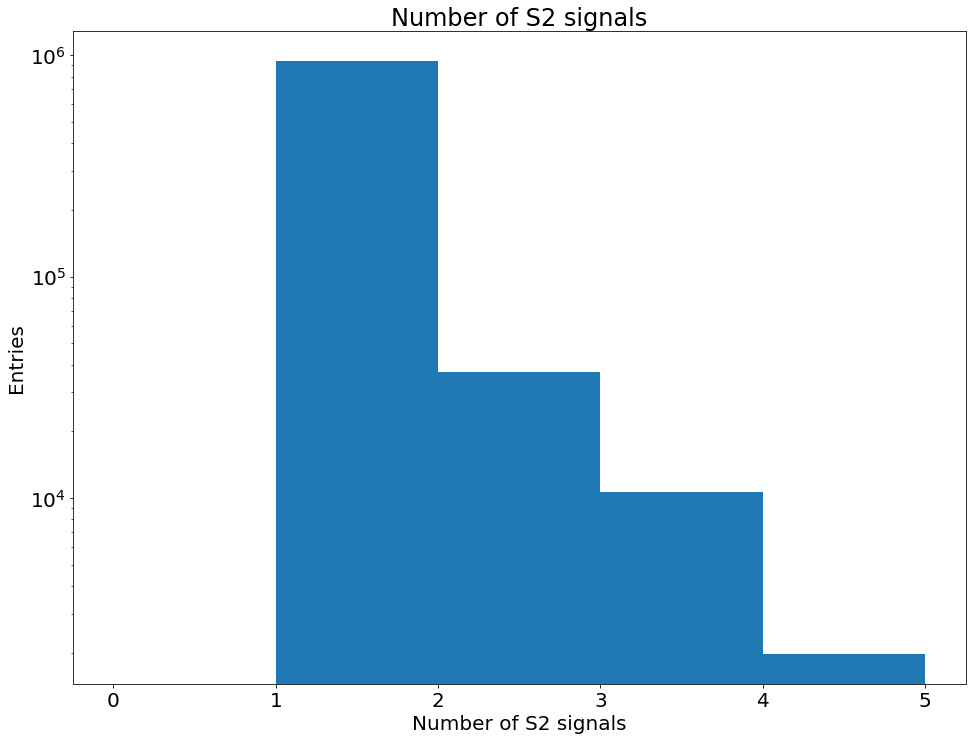

In [10]:
hist(S2n, 5, (0, 5))
plt.yscale("log")
labels("Number of S2 signals", "Entries", "Number of S2 signals")
save("NS2")

##### Z distribution

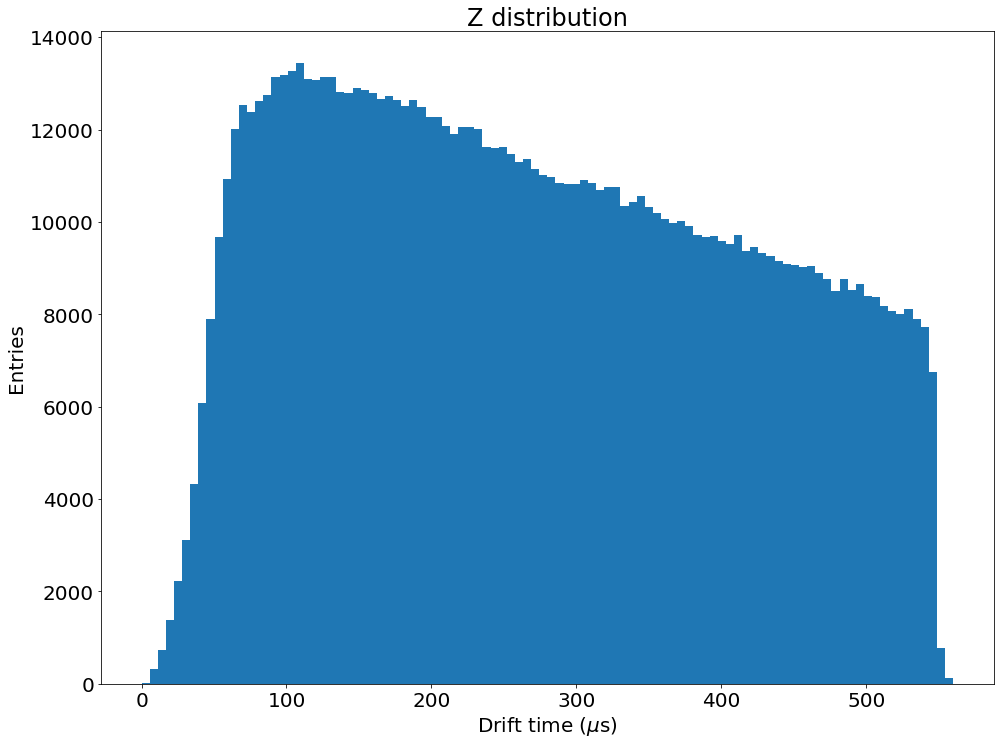

In [11]:
hist(Z, Zbins)
labels("Drift time ($\mu$s)", "Entries", "Z distribution")
save("Z")

##### Trigger rate

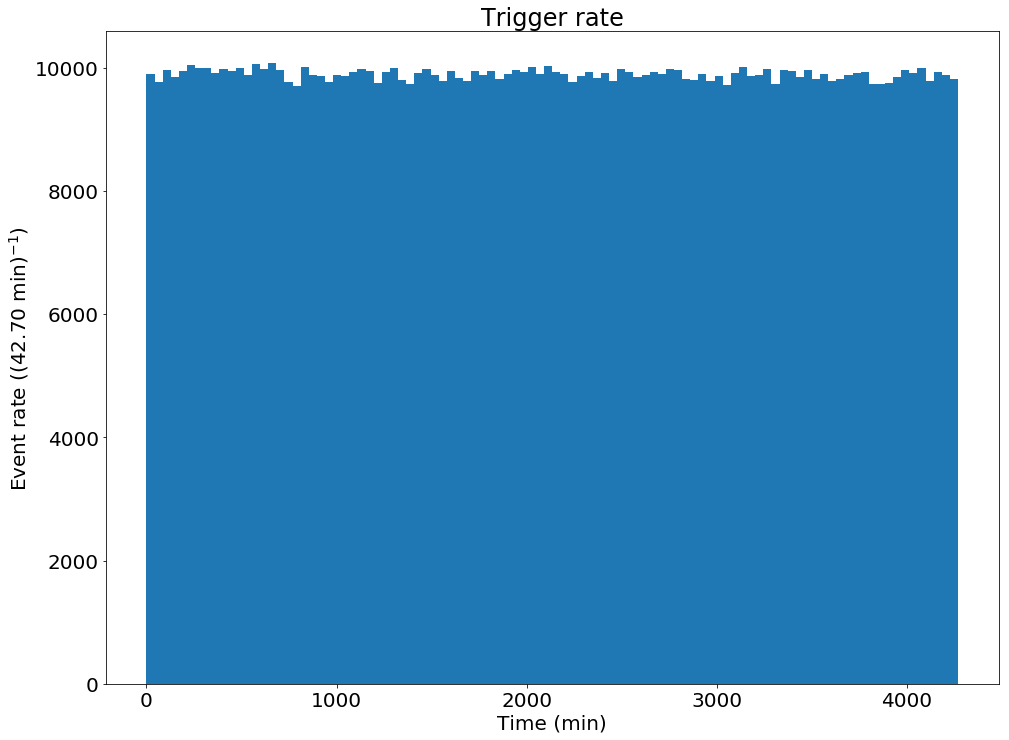

In [12]:
y, x, _ = hist(T, 100, (0, np.max(T)))
dt      = np.diff(x)[0]

labels( "Time (min)",
       f"Event rate (({dt:.2f} min)$^{{-1}}$)",
        "Trigger rate")
save("EventRate")

##### Raw spectrum

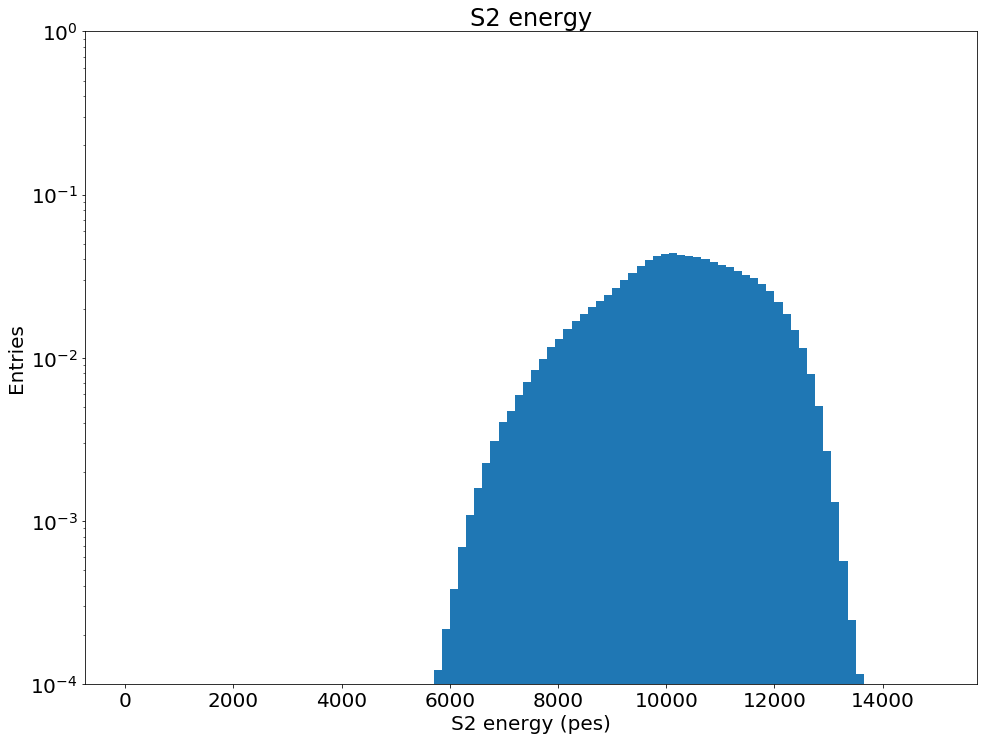

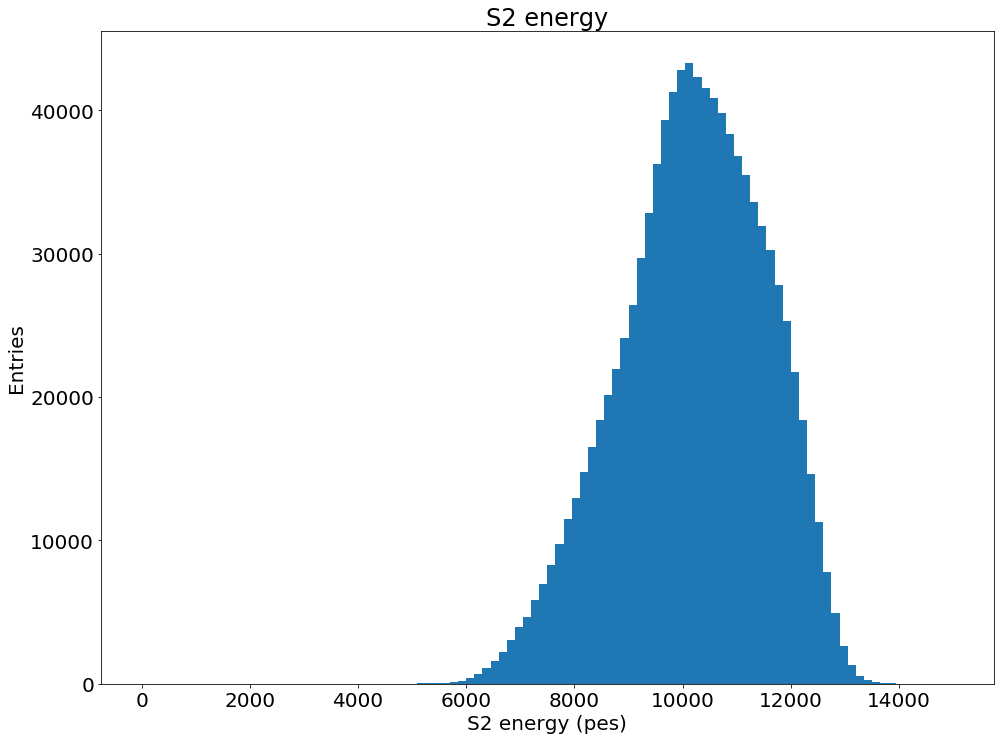

In [13]:
pdf(S2e, S2Ebins)
labels("S2 energy (pes)", "Entries", "S2 energy")
save("Raw_energy_wide")

hist(S2e, S2Ebins)
labels("S2 energy (pes)", "Entries", "S2 energy")
save("Raw_energy")

##### Drift velocity

Max drift length = 548.605 +- 0.043
Drift velocity   = 0.96973 +- 0.00008


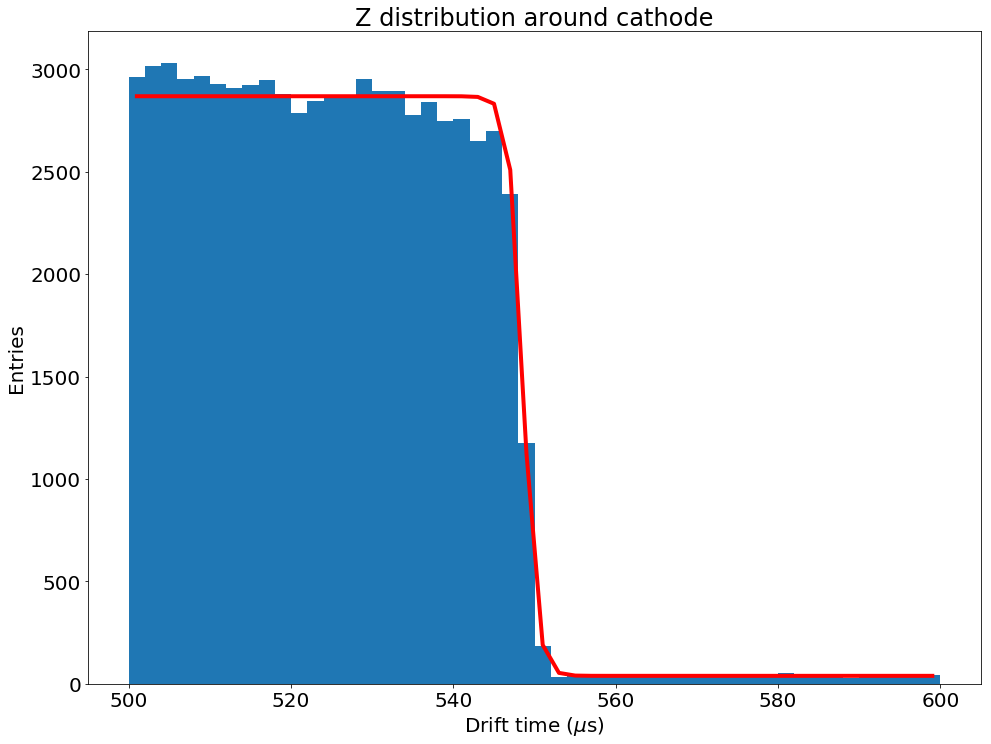

In [14]:
y, x, _  = hist(Z, DVbins)

sigmoid  = lambda x, A, B, C, D: A / (1 + np.exp((x - B) / C)) + D
seed     = np.max(y), np.mean(Zrange_DV), np.diff(Zrange_DV)[0] / 100, np.min(y)
f        = fitf.fit(sigmoid, x, y, seed, sigma=poisson_sigma(y))

z_cathode = DB.DetectorGeo().ZMAX[0]
dv        = z_cathode / f.values[1]
u_dv      =        dv / f.values[1] * f.errors[1]

plt.plot(x, f.fn(x), lw=global_linewidth, c=global_linecolor)
labels("Drift time ($\mu$s)", "Entries", "Z distribution around cathode")

print("Max drift length = {:.3f} +- {:.3f}".format(f.values[1], f.errors[1]))
print("Drift velocity   = {:.5f} +- {:.5f}".format(dv, u_dv))
save("Drift_velocity")

##### S1 distributions

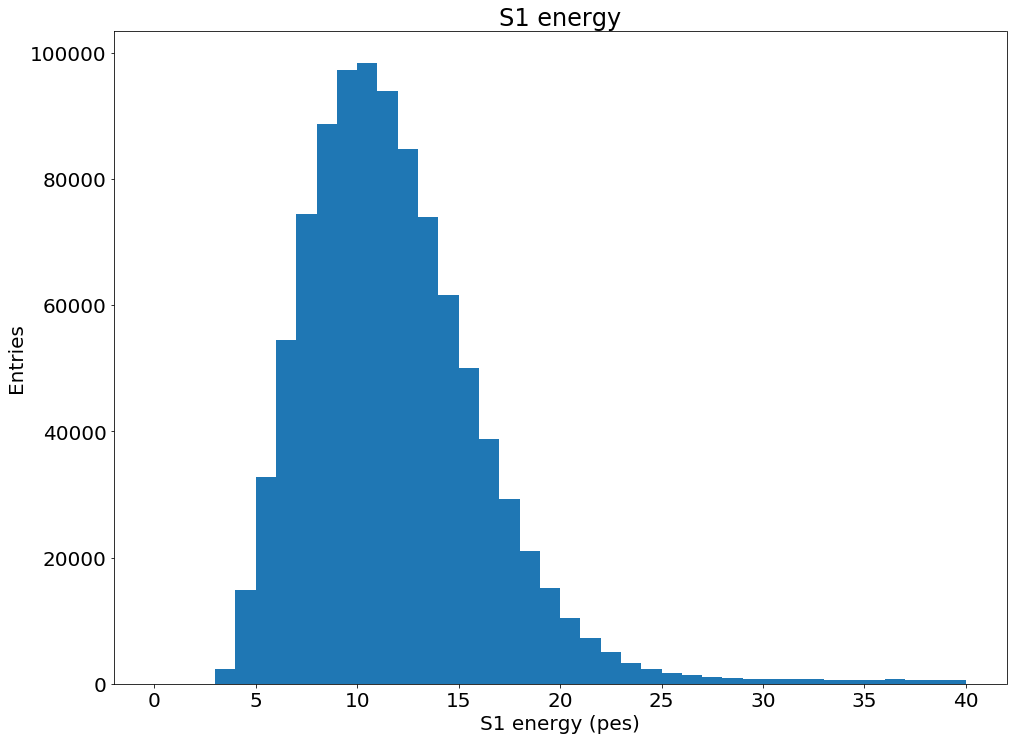

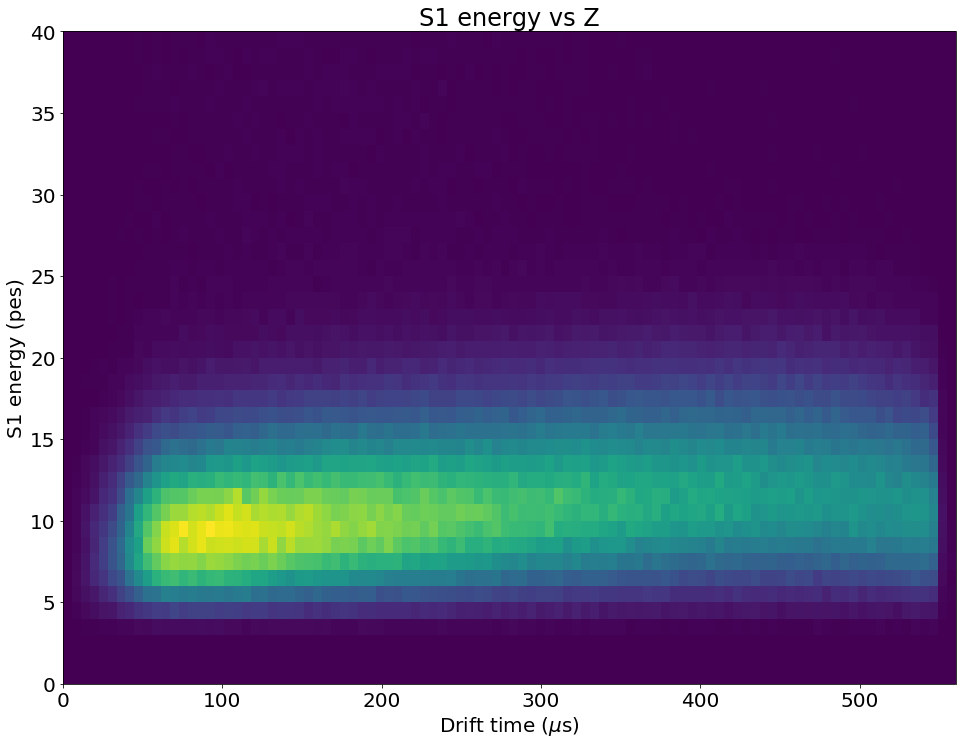

In [15]:
hist(S1e, S1Ebins)
labels("S1 energy (pes)", "Entries", "S1 energy")
save("S1energy")

hist2d(Z, S1e, (Zbins, S1Ebins))
labels("Drift time ($\mu$s)", "S1 energy (pes)", "S1 energy vs Z")
save("S1energyZ")

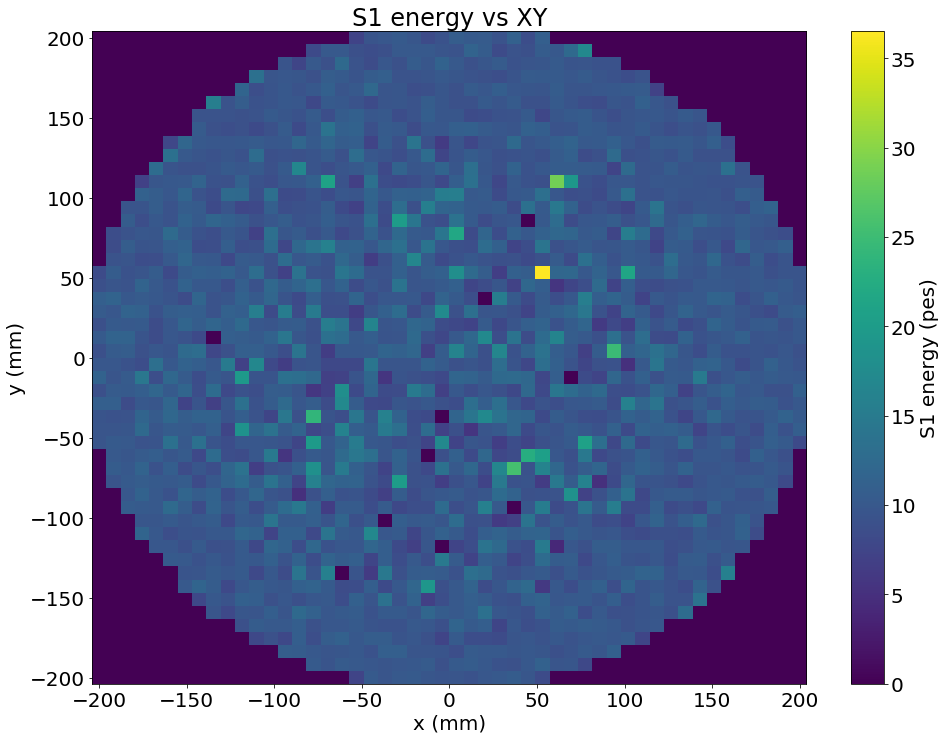

In [16]:
short_drift = coref.in_range(  Z,   0,   50) &\
              coref.in_range(S1e, *S1Erange)

x, y, S, u_S = fitf.profileXY(X  [short_drift],
                              Y  [short_drift],
                              S1e[short_drift],
                              XYnbins, XYnbins,
                              XYrange, XYrange)
_, cb = display_matrix(x, y, S)
cb.set_label("S1 energy (pes)")
labels("x (mm)", "y (mm)", "S1 energy vs XY")
save("S1energyXY")

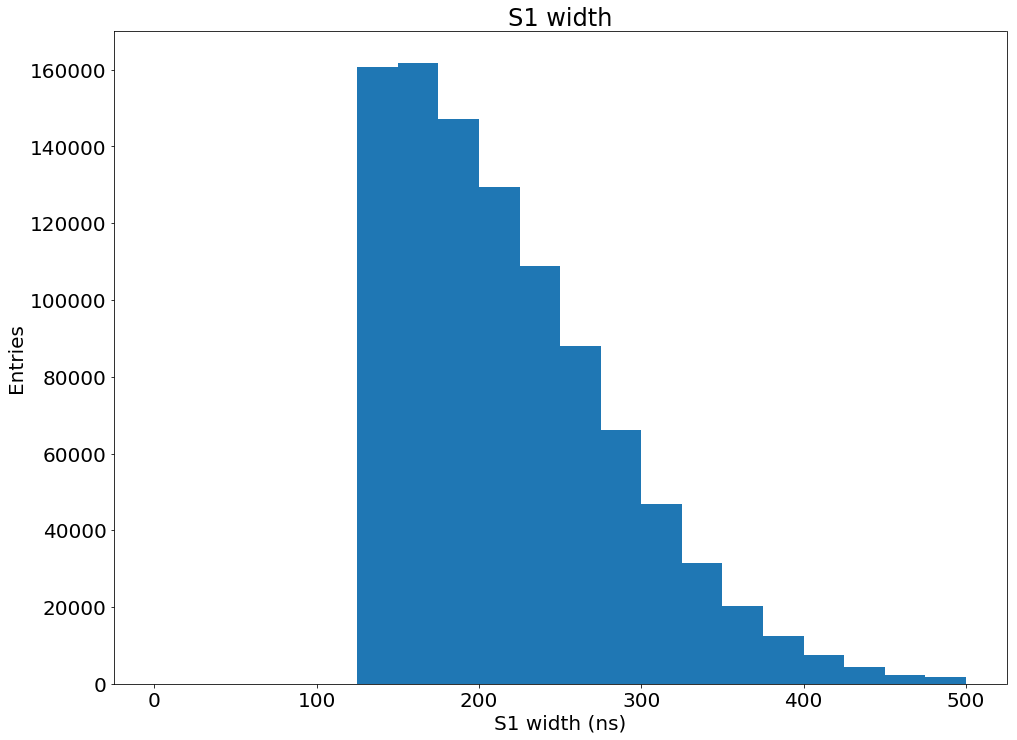

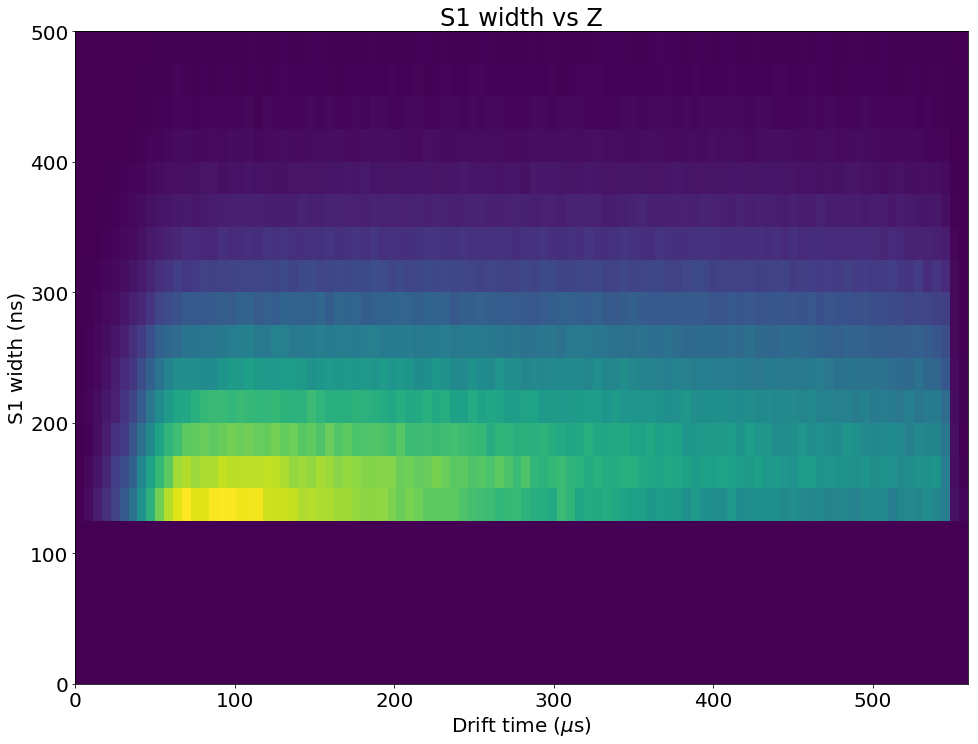

In [17]:
hist(S1w, S1Wbins)
labels("S1 width (ns)", "Entries", "S1 width")
save("S1width")

hist2d(Z, S1w, (Zbins, S1Wbins))
labels("Drift time ($\mu$s)", "S1 width (ns)", "S1 width vs Z")
save("S1widthZ")

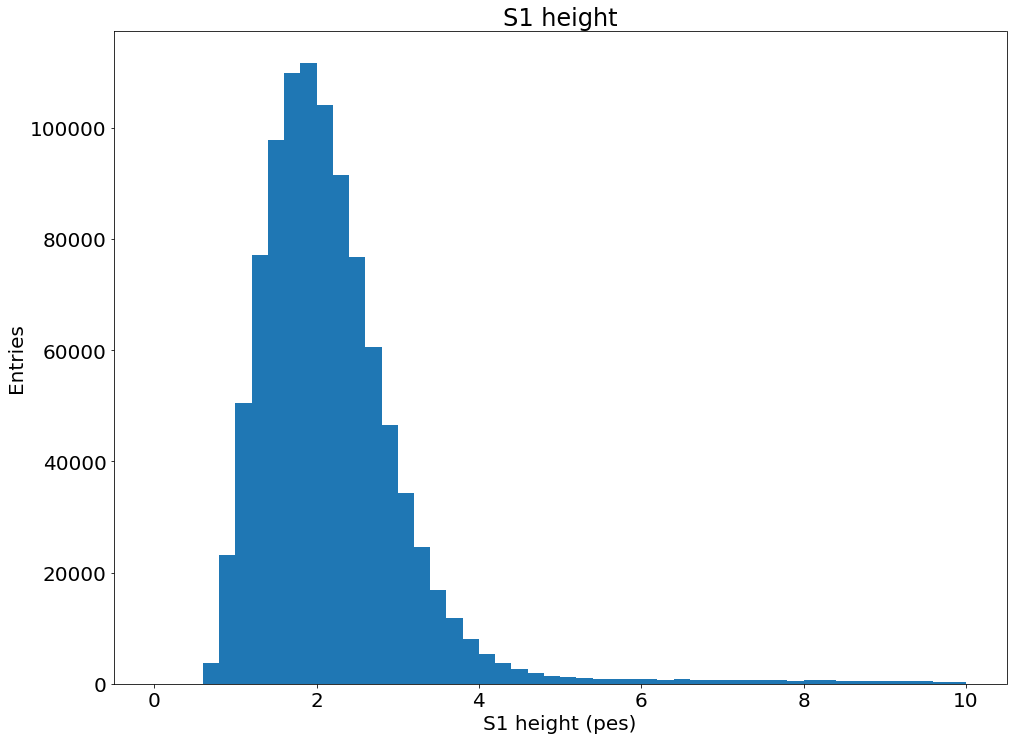

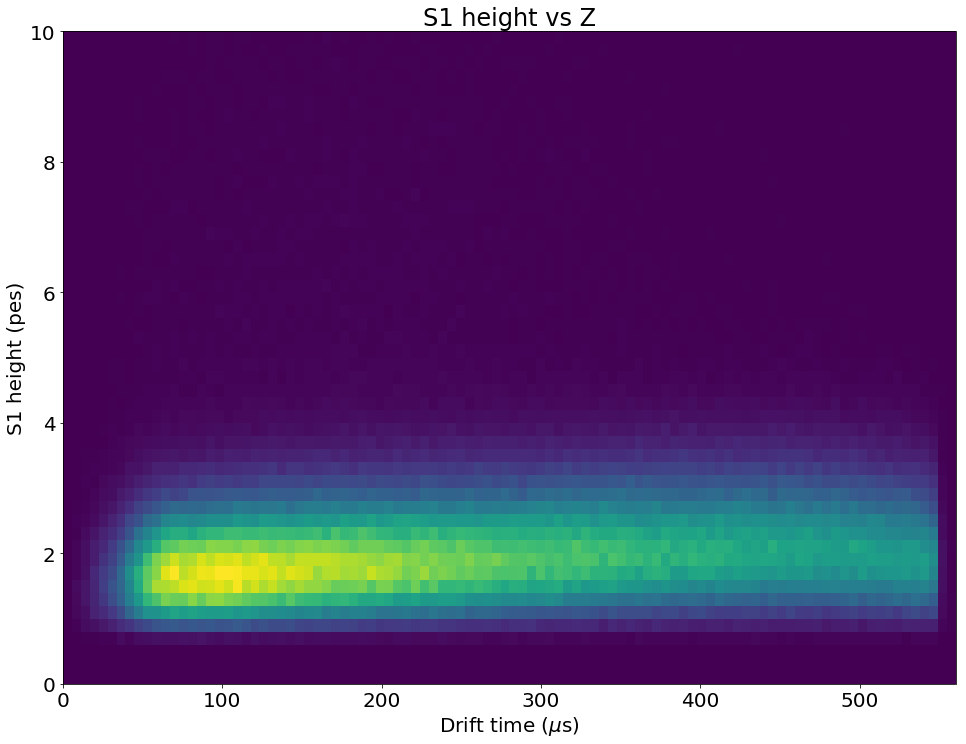

In [18]:
hist(S1h, S1Hbins)
labels("S1 height (pes)", "Entries", "S1 height")
save("S1height")

hist2d(Z, S1h, (Zbins, S1Hbins))
labels("Drift time ($\mu$s)", "S1 height (pes)", "S1 height vs Z")
save("S1heightZ")

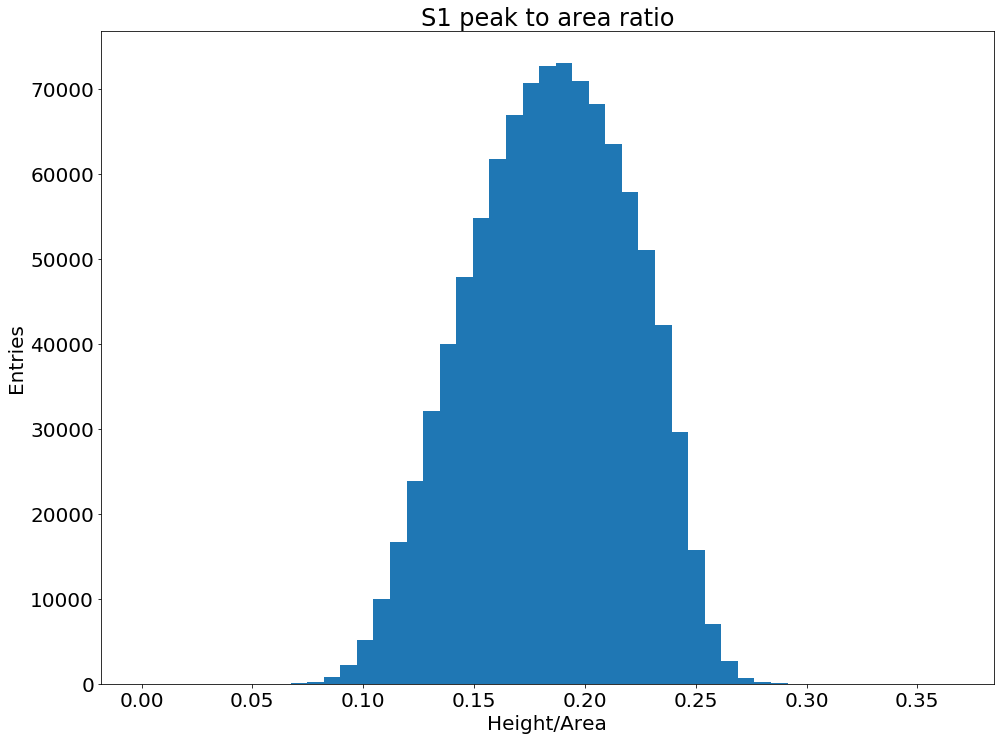

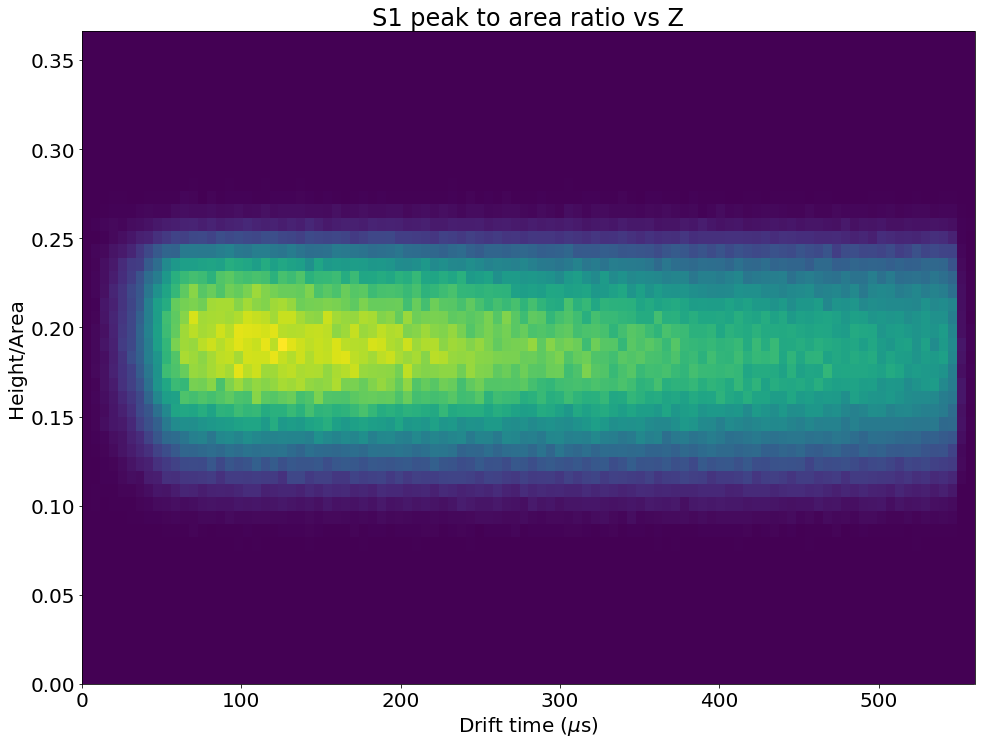

In [19]:
S1r   = S1h / S1e
_bins = np.linspace(0, np.max(S1r), 50)

hist(S1r, _bins)
labels("Height/Area", "Entries", "S1 peak to area ratio")
save("S1Peak2Area")

hist2d(Z, S1r, (Zbins, _bins))
labels("Drift time ($\mu$s)", "Height/Area", "S1 peak to area ratio vs Z")
save("S1Peak2AreaZ")

##### S2 distributions

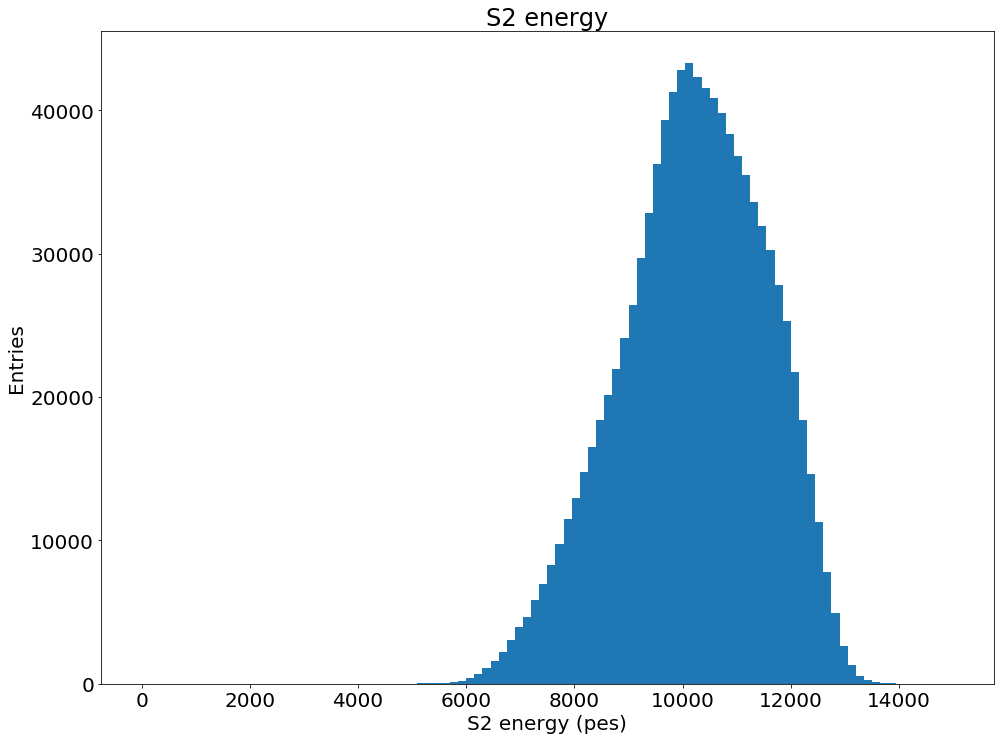

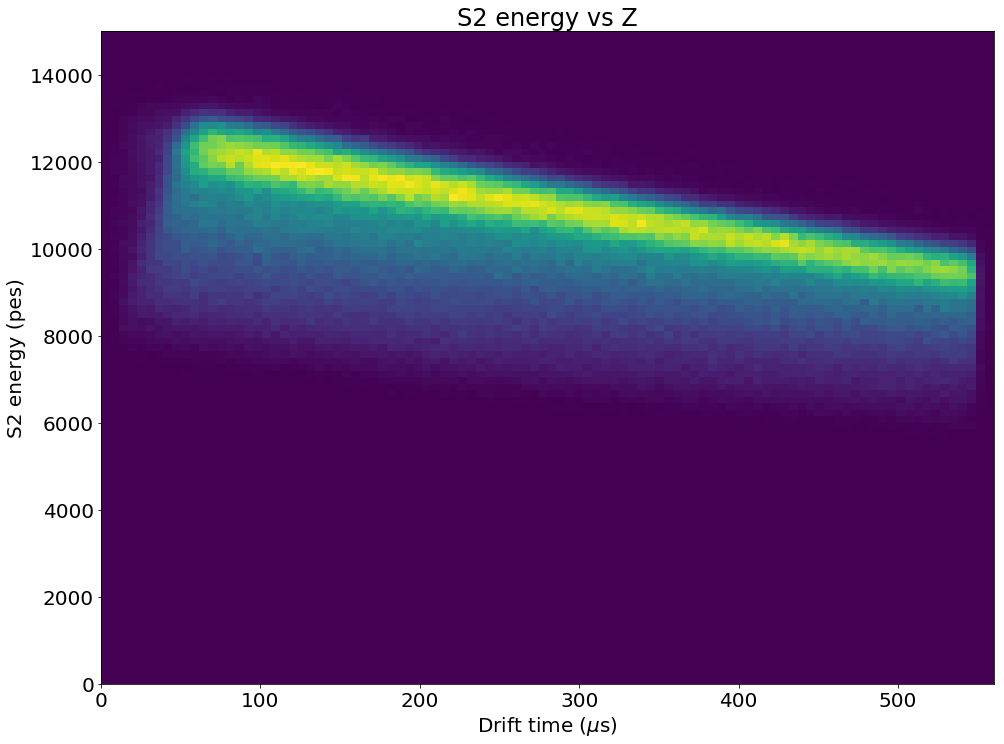

In [20]:
hist(S2e, S2Ebins)
labels("S2 energy (pes)", "Entries", "S2 energy")
save("S2energy")

hist2d(Z, S2e, (Zbins, S2Ebins))
labels("Drift time ($\mu$s)", "S2 energy (pes)", "S2 energy vs Z")
save("S2energyZ")

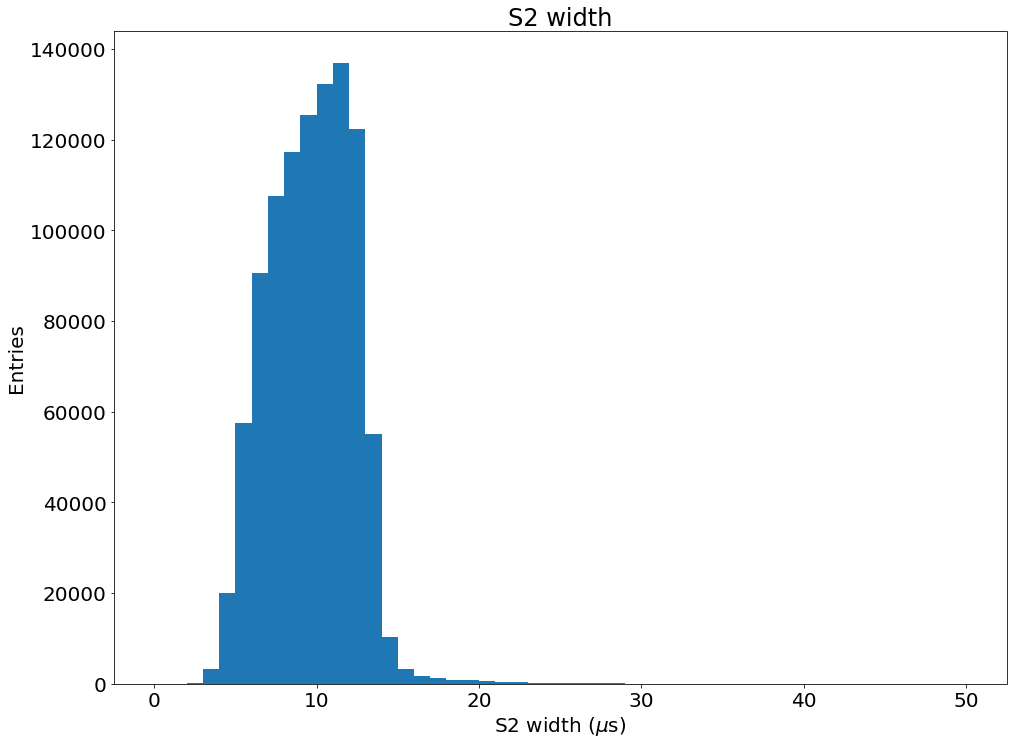

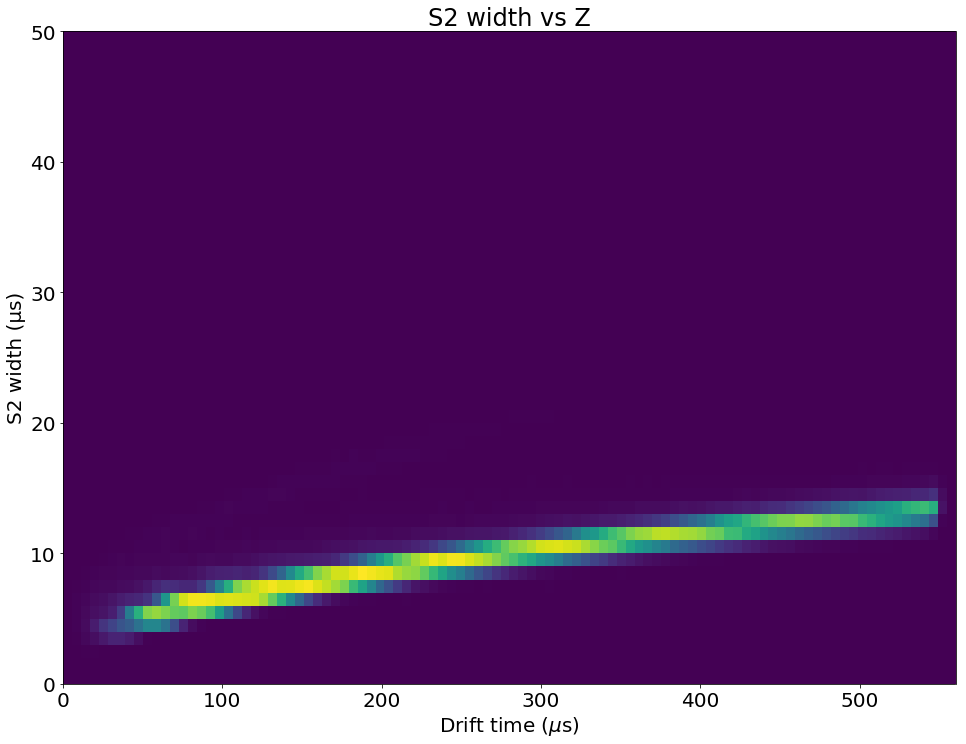

In [21]:
hist(S2w, S2Wbins)
labels("S2 width ($\mu$s)", "Entries", "S2 width")
save("S2width")

hist2d(Z, S2w, (Zbins, S2Wbins))
labels("Drift time ($\mu$s)", "S2 width (µs)", "S2 width vs Z")
save("S2widthZ")

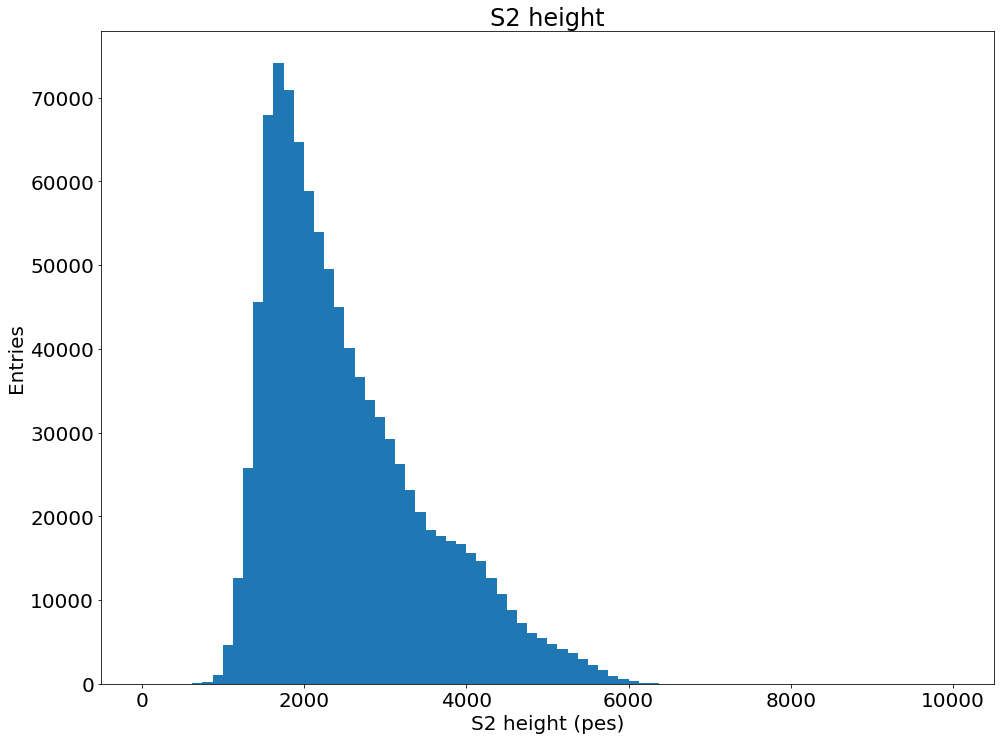

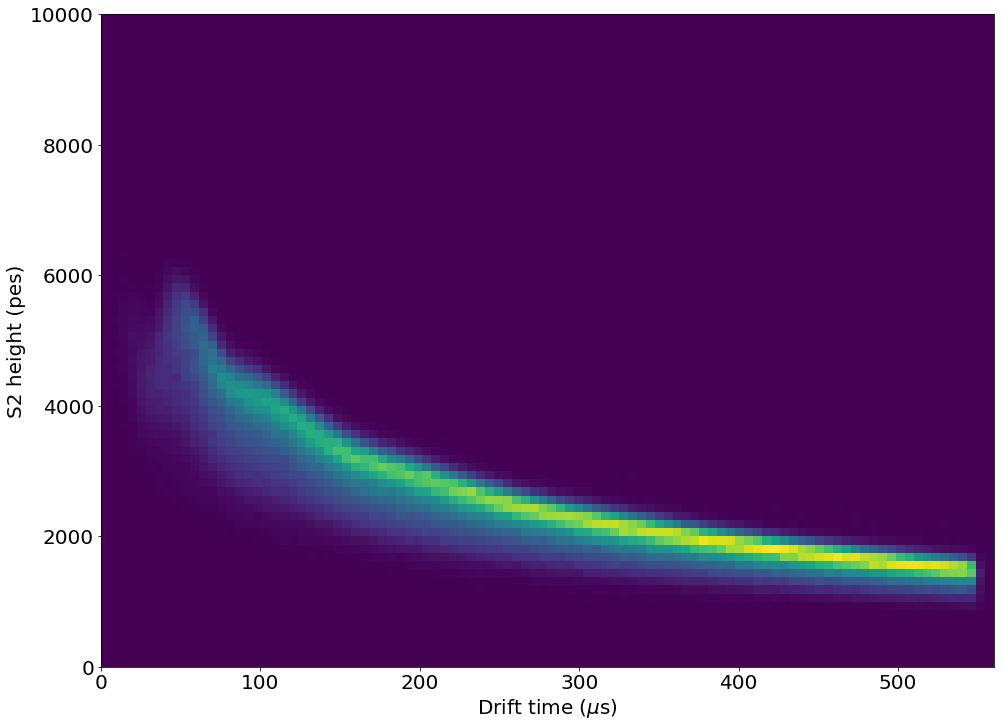

In [22]:
hist(S2h, S2Hbins)
labels("S2 height (pes)", "Entries", "S2 height")
save("S2height")

hist2d(Z, S2h, (Zbins, S2Hbins))
labels("Drift time ($\mu$s)", "S2 height (pes)")
save("S2heightZ")

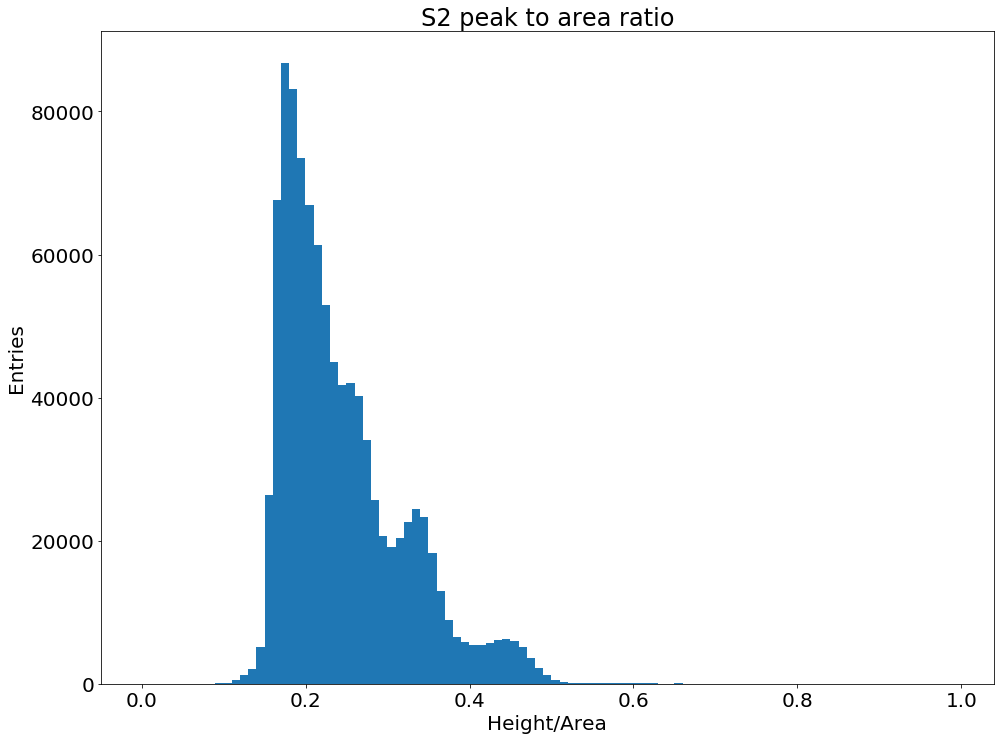

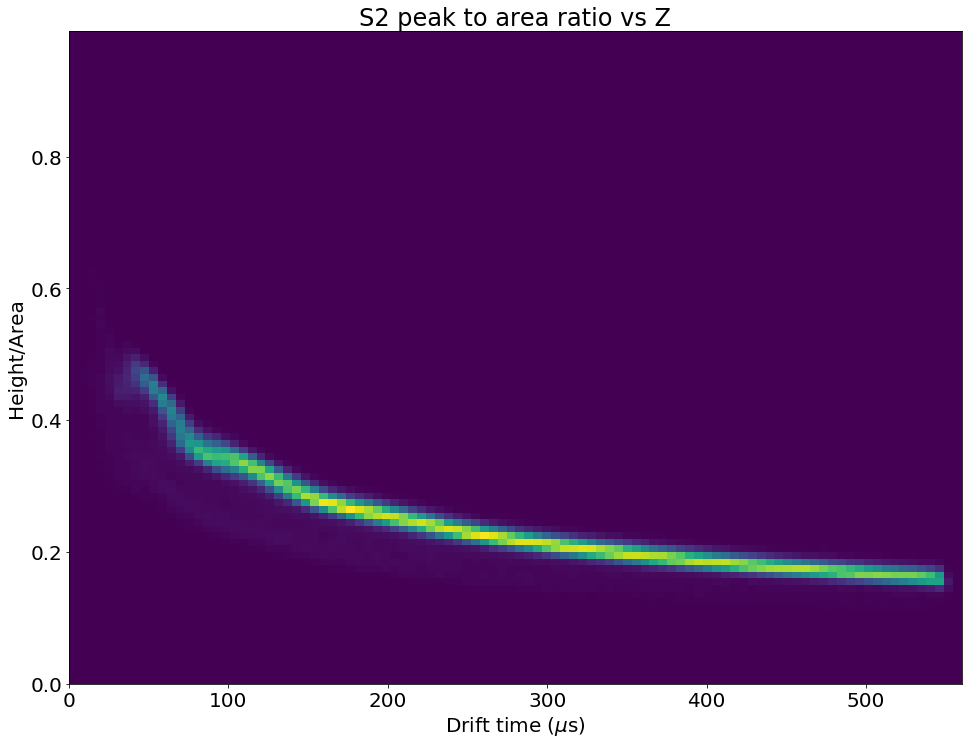

In [23]:
S2r   = S2h / S2e
_bins = np.linspace(0, np.max(S2r), 100)


hist(S2r, _bins)
labels("Height/Area", "Entries", "S2 peak to area ratio")
save("S2Peak2Area")

hist2d(Z, S2r, (Zbins, _bins))
labels("Drift time ($\mu$s)", "Height/Area", "S2 peak to area ratio vs Z")
save("S2Peak2AreaZ")

# S2 vs S1

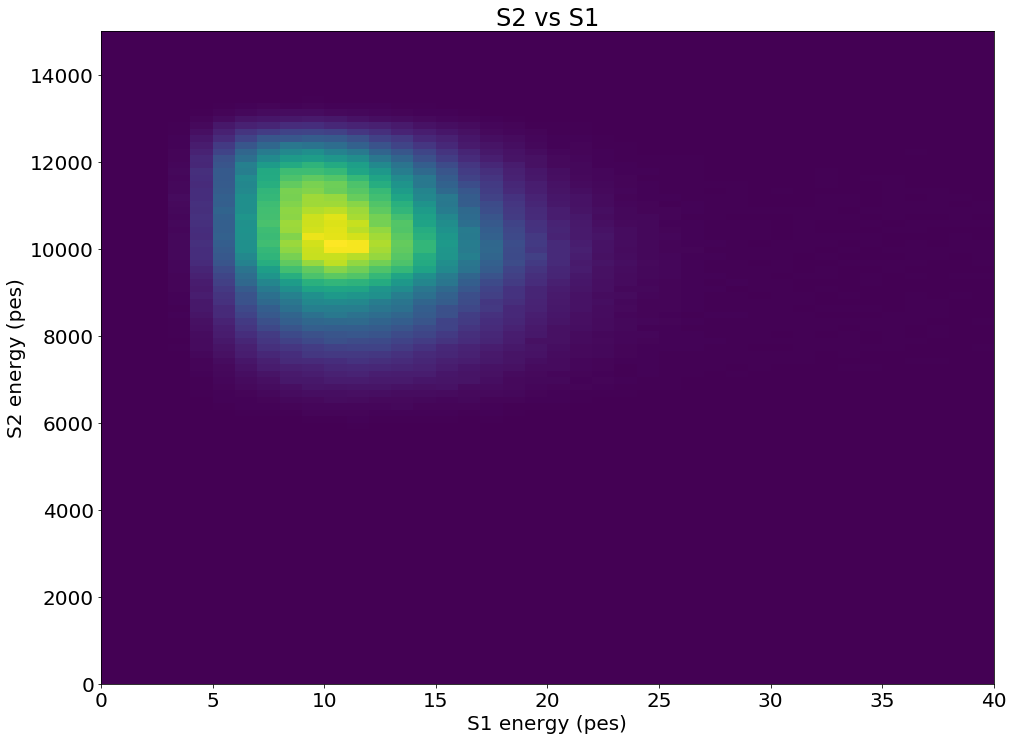

In [24]:
hist2d(S1e, S2e, (S1Ebins, S2Ebins))
labels("S1 energy (pes)", "S2 energy (pes)", "S2 vs S1")
save("S2S1")

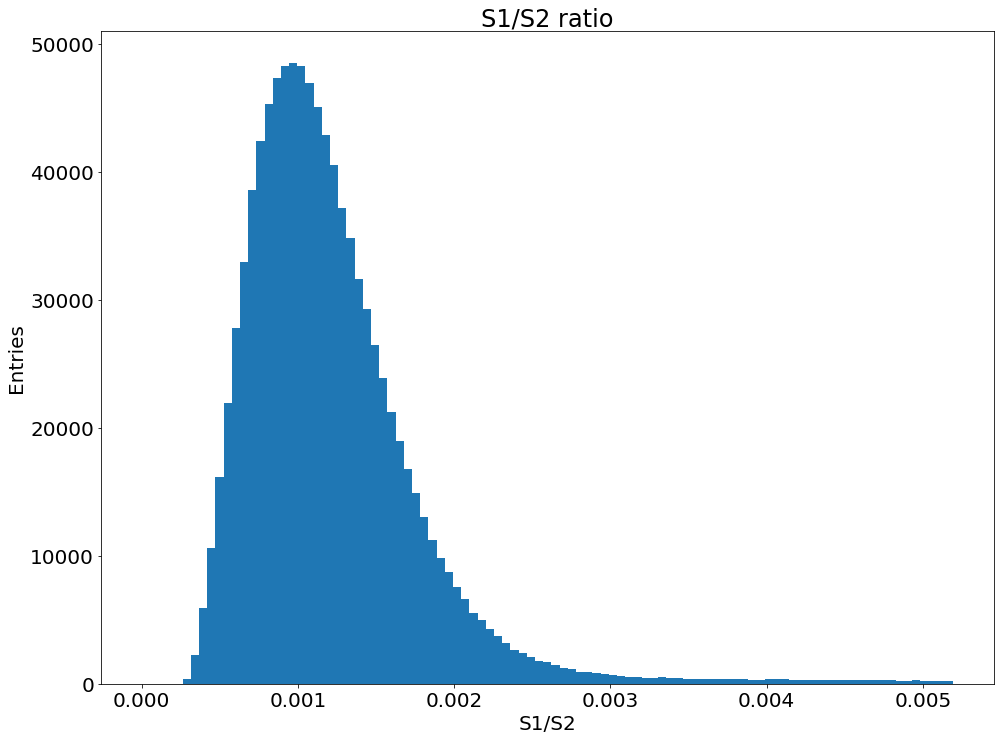

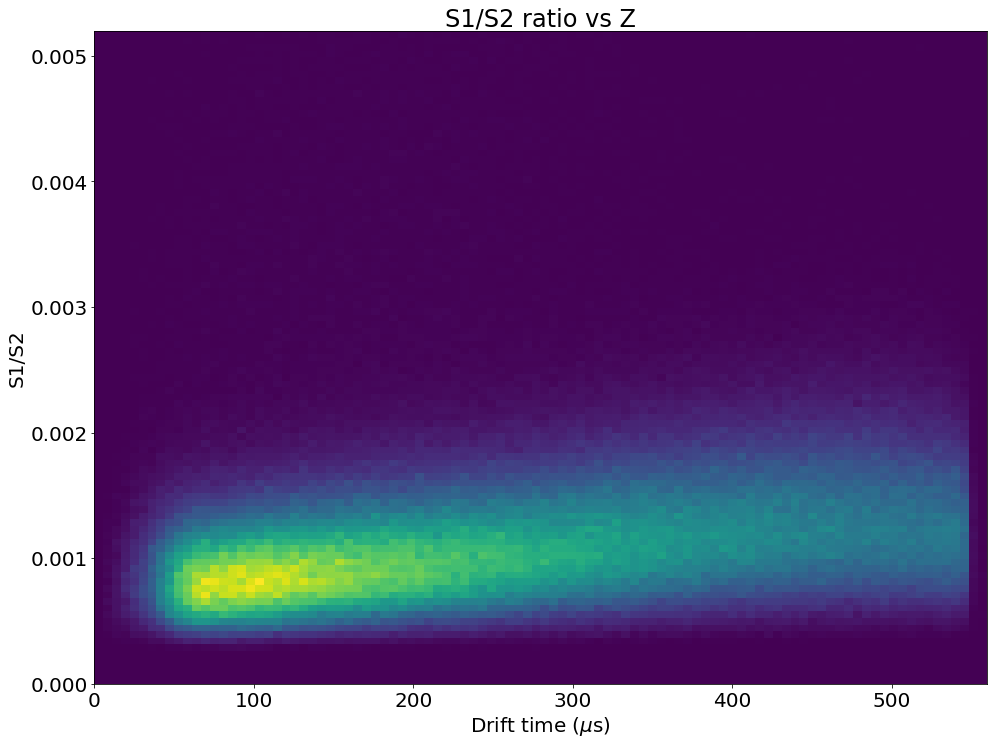

In [25]:
S12r  = S1e / S2e
_bins = np.linspace(0, np.mean(S12r) + 3 * np.std(S12r), 100)

hist(S12r, _bins)
labels("S1/S2", "Entries", "S1/S2 ratio")
save("S12ratio")

hist2d(Z, S12r, (Zbins, _bins))
labels("Drift time ($\mu$s)", "S1/S2", "S1/S2 ratio vs Z")
save("S12ratioZ")

##### Tracking

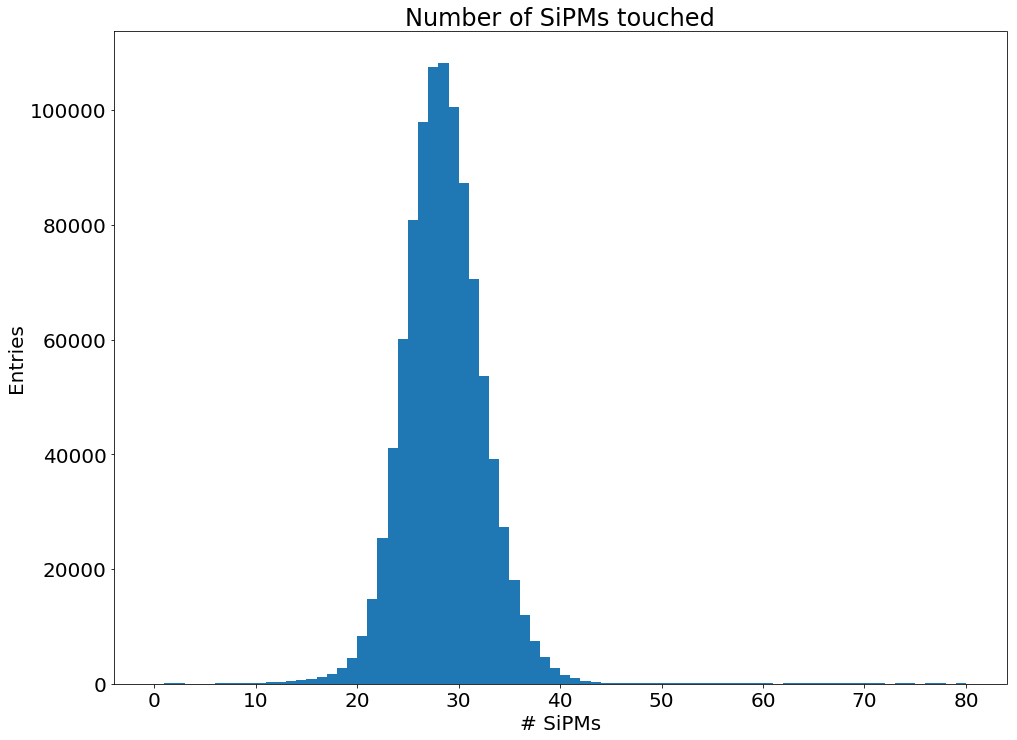

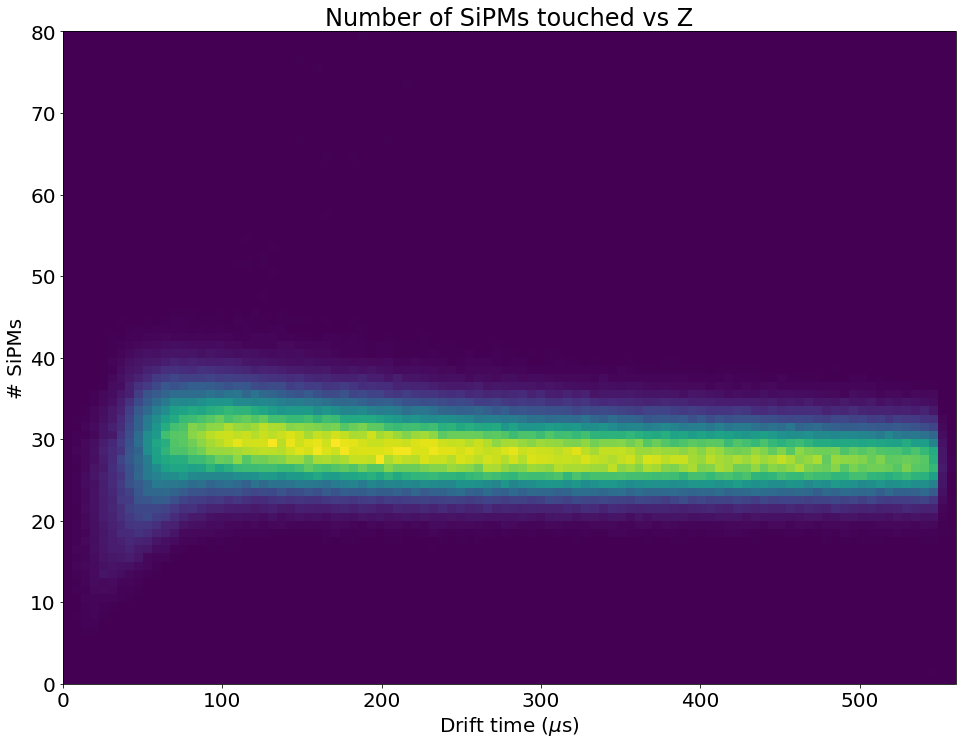

In [26]:
hist(Nsi, NSibins)
labels("# SiPMs", "Entries", "Number of SiPMs touched")
save("Nsipm")

hist2d(Z, Nsi, (Zbins, NSibins))
labels("Drift time ($\mu$s)", "# SiPMs", "Number of SiPMs touched vs Z")
save("NsipmZ")

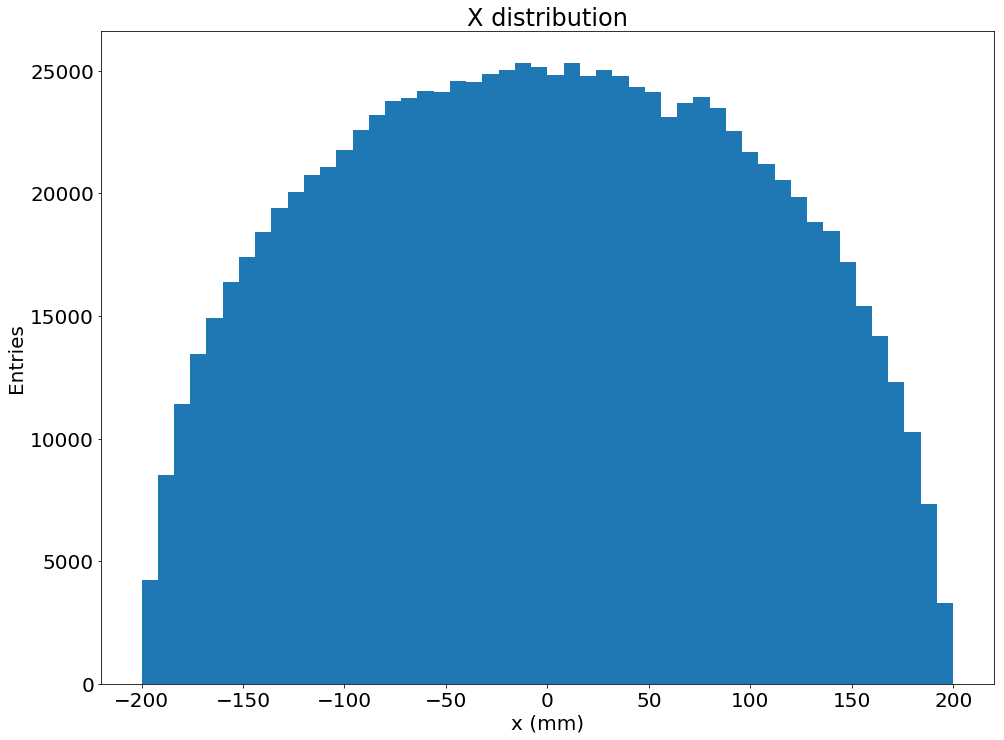

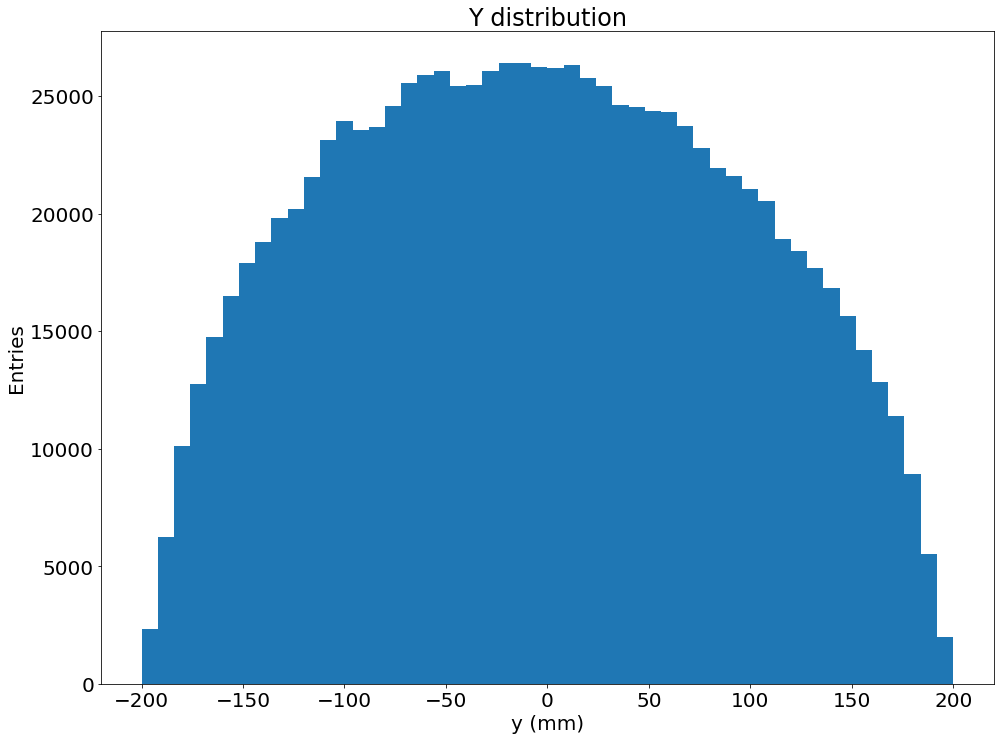

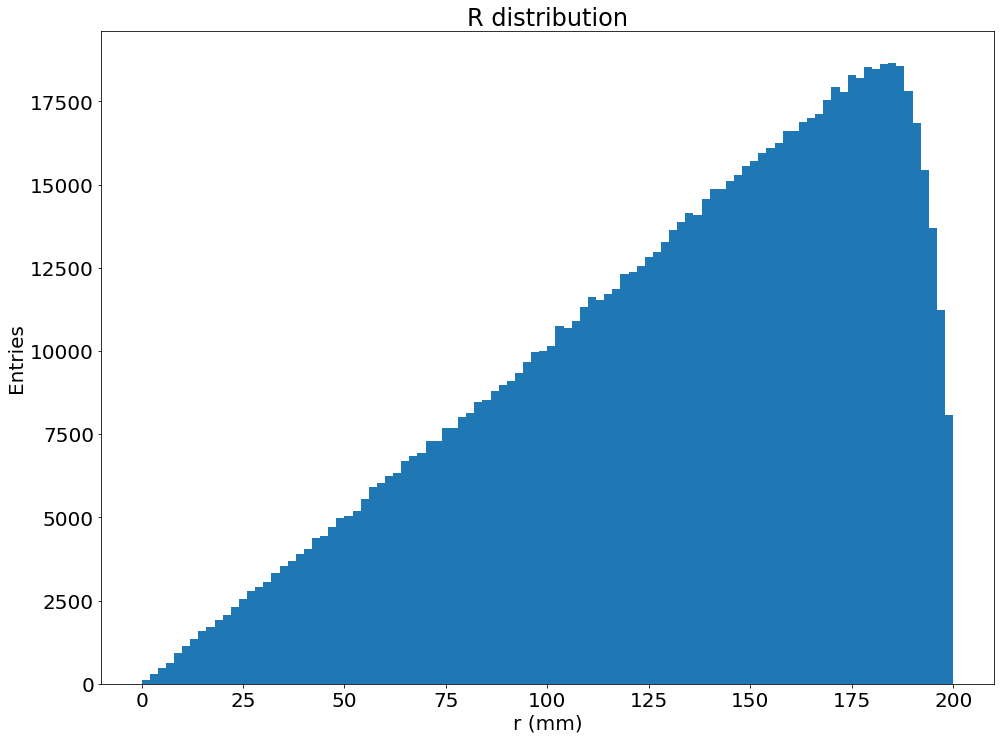

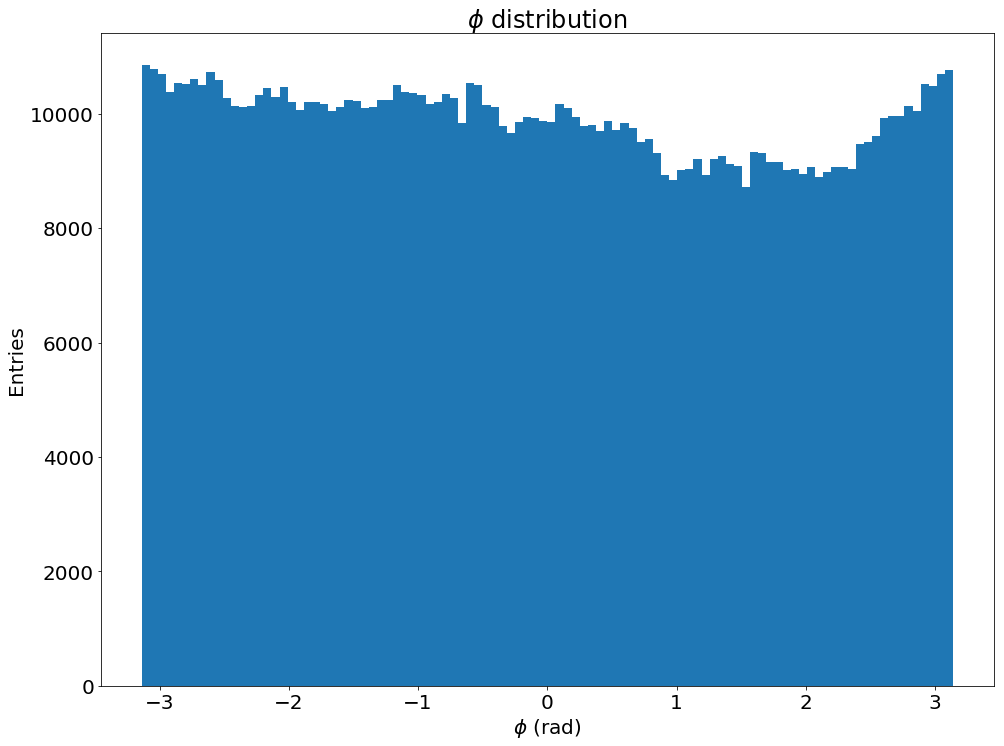

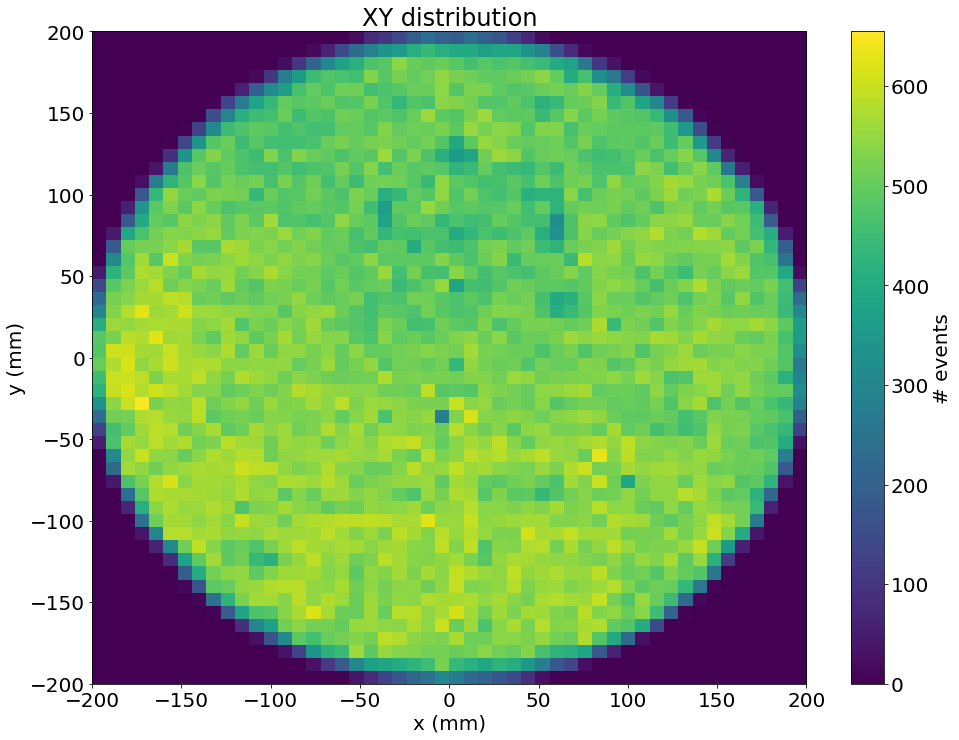

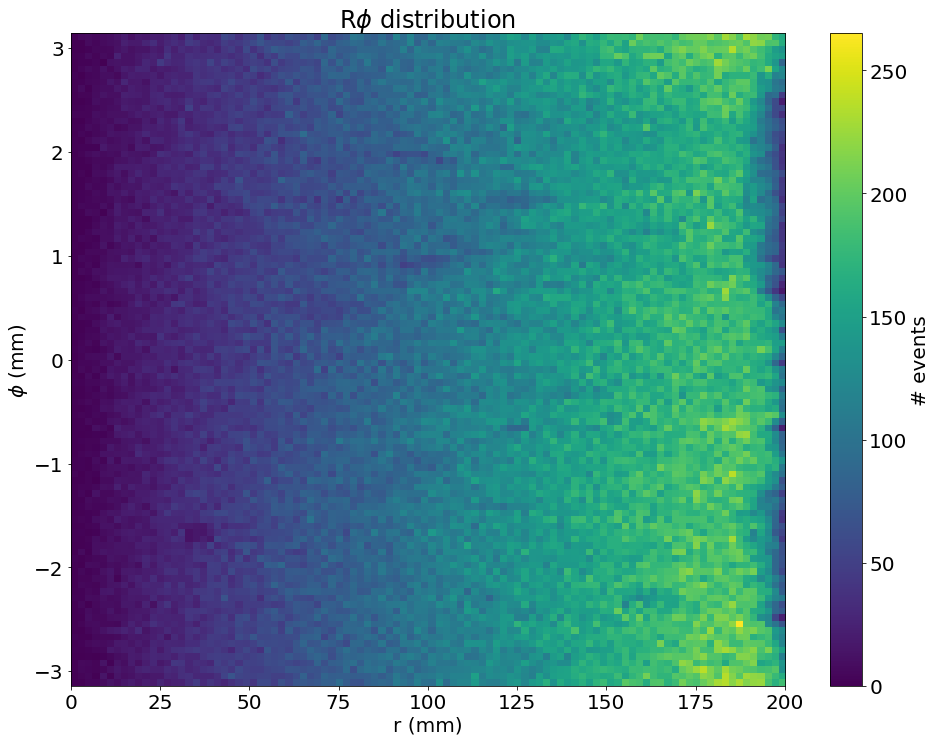

In [27]:
hist(X, XYbins)
labels("x (mm)", "Entries", "X distribution")
save("X")

hist(Y, XYbins)
labels("y (mm)", "Entries", "Y distribution")
save("Y")

hist(R, Rbins)
labels("r (mm)", "Entries", "R distribution")
save("R")

hist(Phi, Phibins)
labels("$\phi$ (rad)", "Entries", "$\phi$ distribution")
save("Phi")

hist2d(X, Y, (XYbins, XYbins))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)", "XY distribution")
save("XY")

hist2d(R, Phi, (Rbins, Phibins))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)", "R$\phi$ distribution")
save("RPhi")

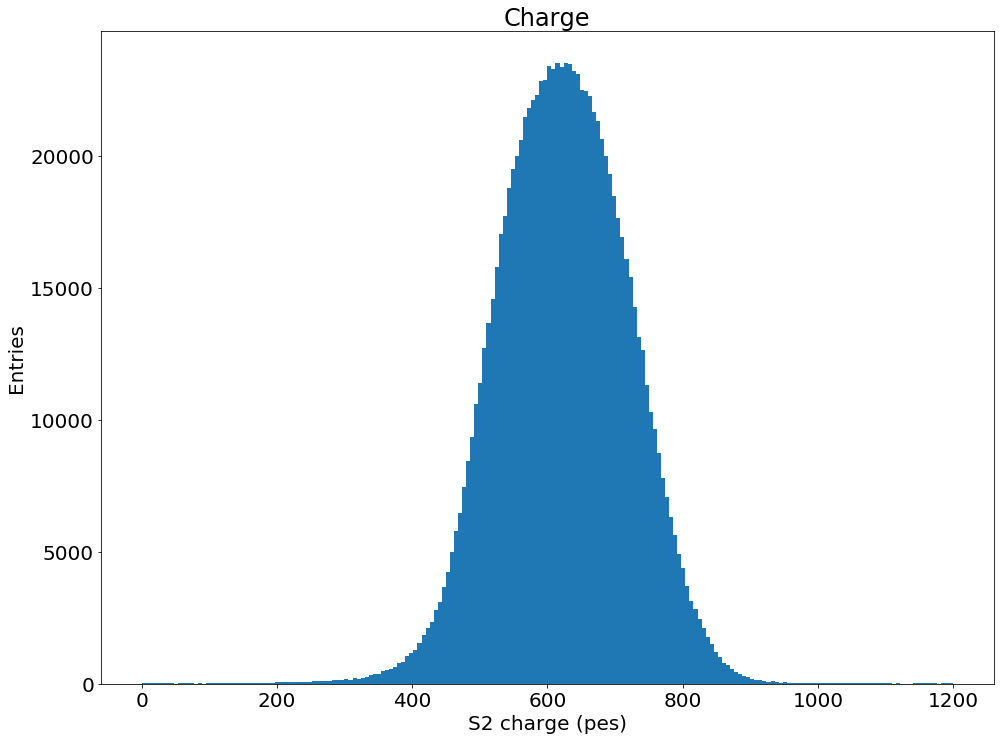

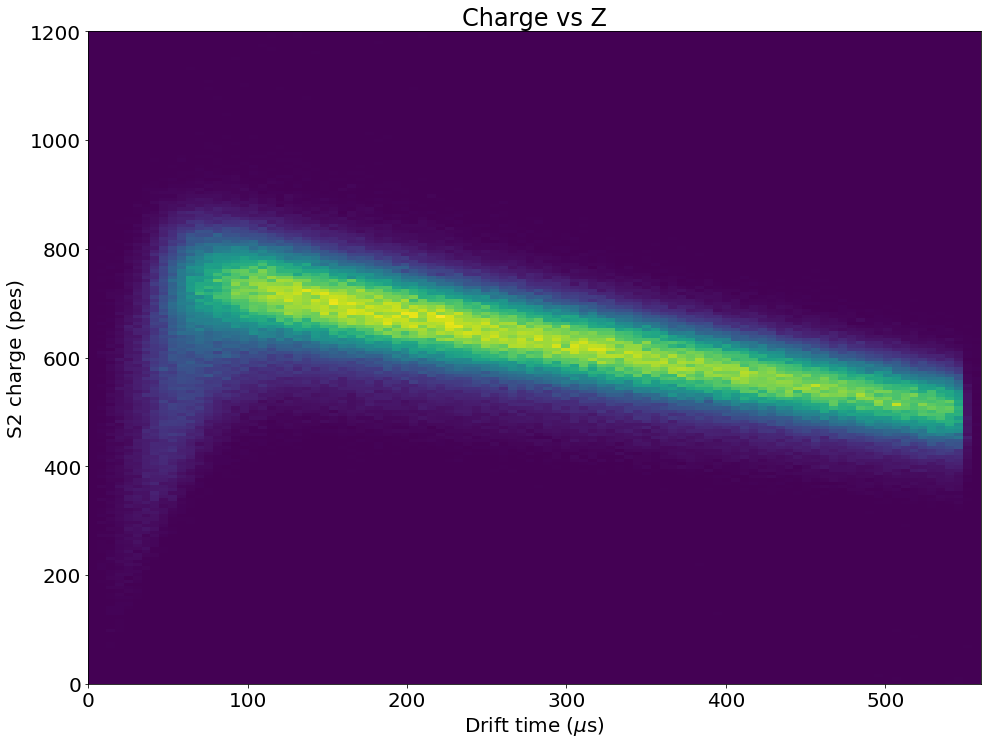

In [28]:
hist(S2q, Qbins)
labels("S2 charge (pes)", "Entries", "Charge")
save("Q")

hist2d(Z, S2q, (Zbins, Qbins))
labels("Drift time ($\mu$s)", "S2 charge (pes)", "Charge vs Z")
save("QZ")

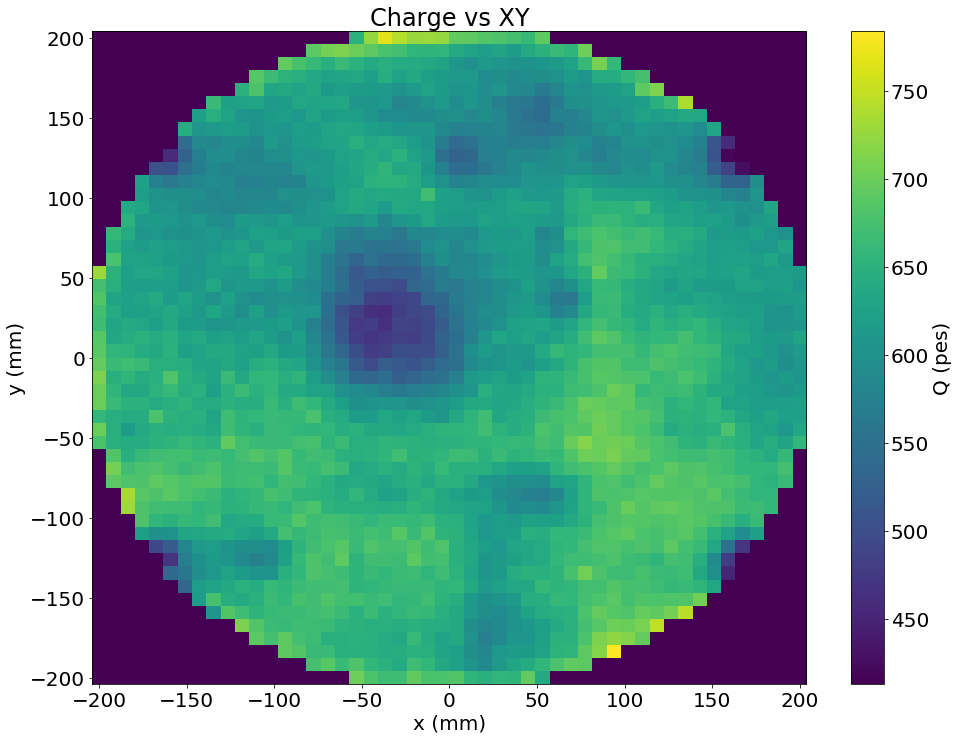

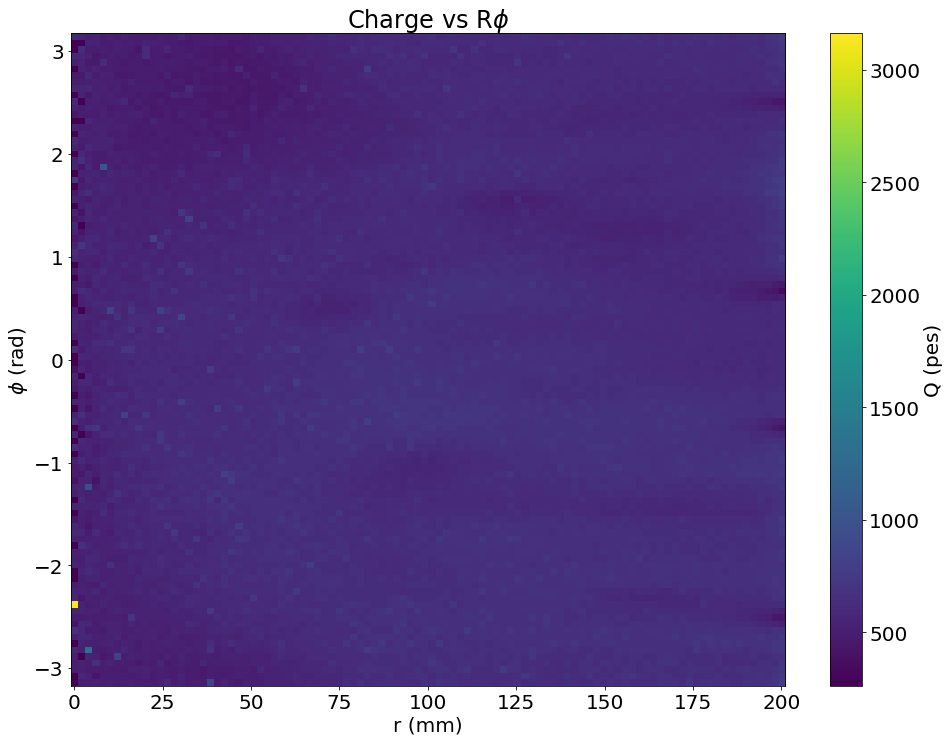

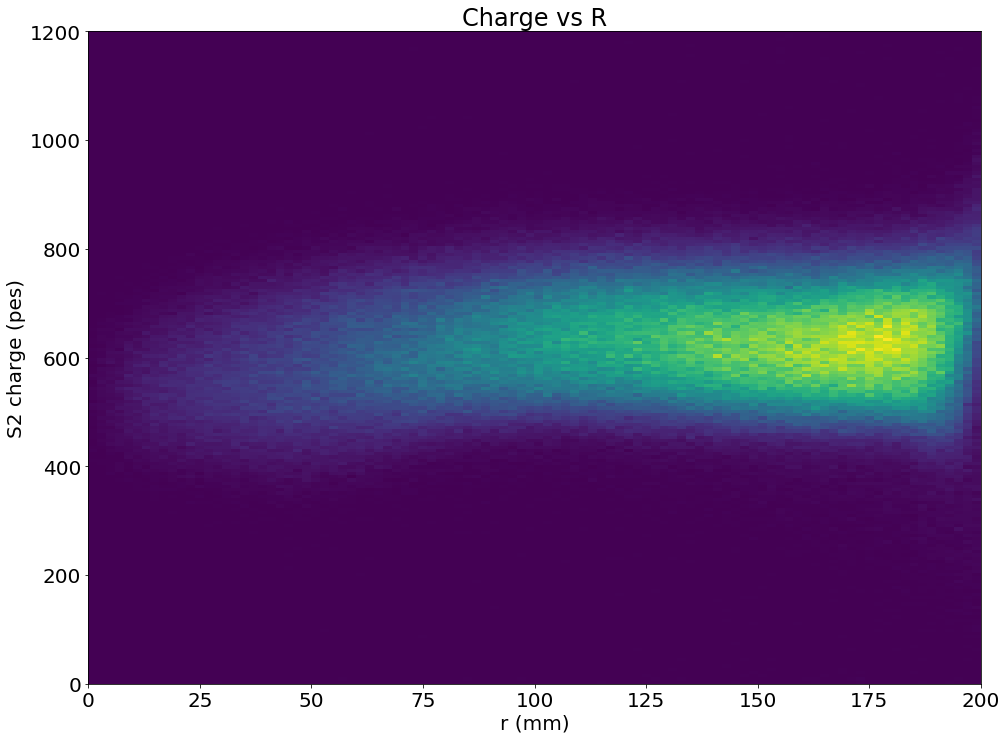

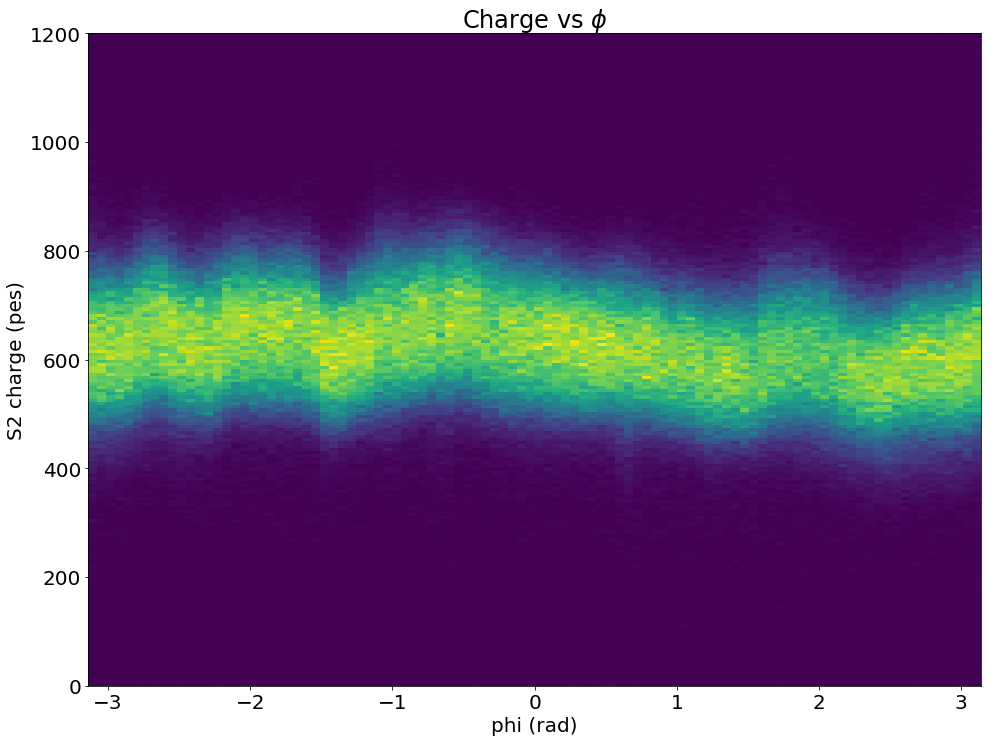

In [29]:
x, y, Q, u_Q = \
fitf.profileXY(X, Y, S2q,
               XYnbins, XYnbins,
               XYrange, XYrange)
_, cb = display_matrix(x, y, Q, vmin=np.min(Q[Q > 0]))
cb.set_label("Q (pes)")
labels("x (mm)", "y (mm)", "Charge vs XY")
save("QXY")

x, y, q, u_q = \
fitf.profileXY(R, Phi, S2q,
               Rnbins, Phinbins,
               Rrange, Phirange)
_, cb = display_matrix(x, y, q, vmin=np.min(q[q > 0]))
cb.set_label("Q (pes)")
labels("r (mm)", "$\phi$ (rad)", "Charge vs R$\phi$")
save("QvsRPhi")

hist2d(R, S2q, (Rbins, Qbins))
labels("r (mm)", "S2 charge (pes)", "Charge vs R")
save("QvsR")

hist2d(Phi, S2q, (Phibins, Qbins))
labels("phi (rad)", "S2 charge (pes)", "Charge vs $\phi$")
save("QvsPhi")

##### Energy dependence

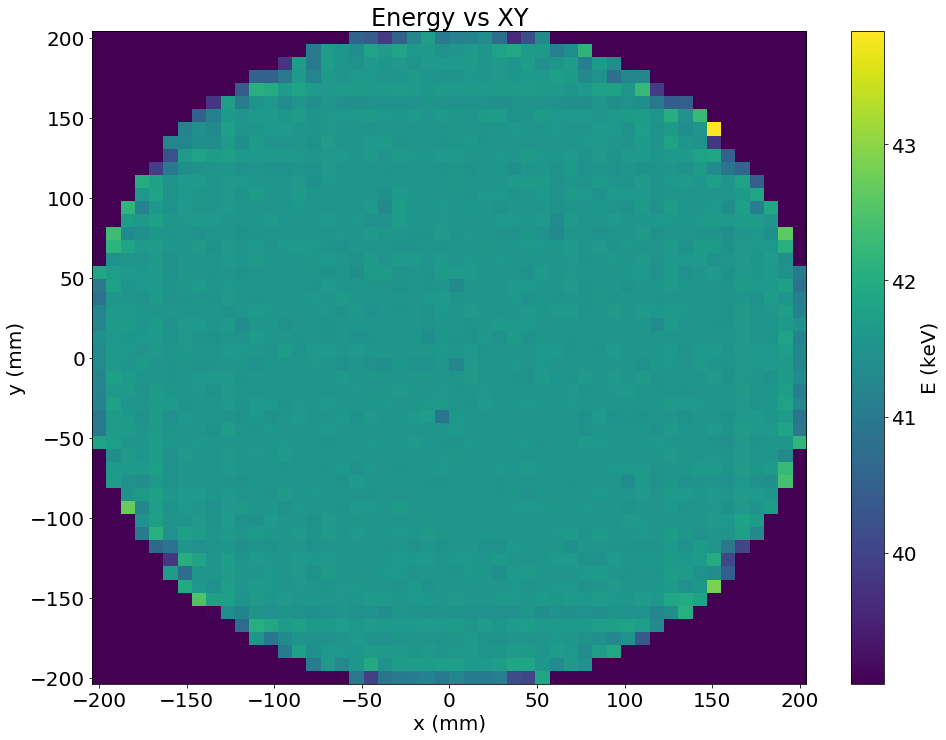

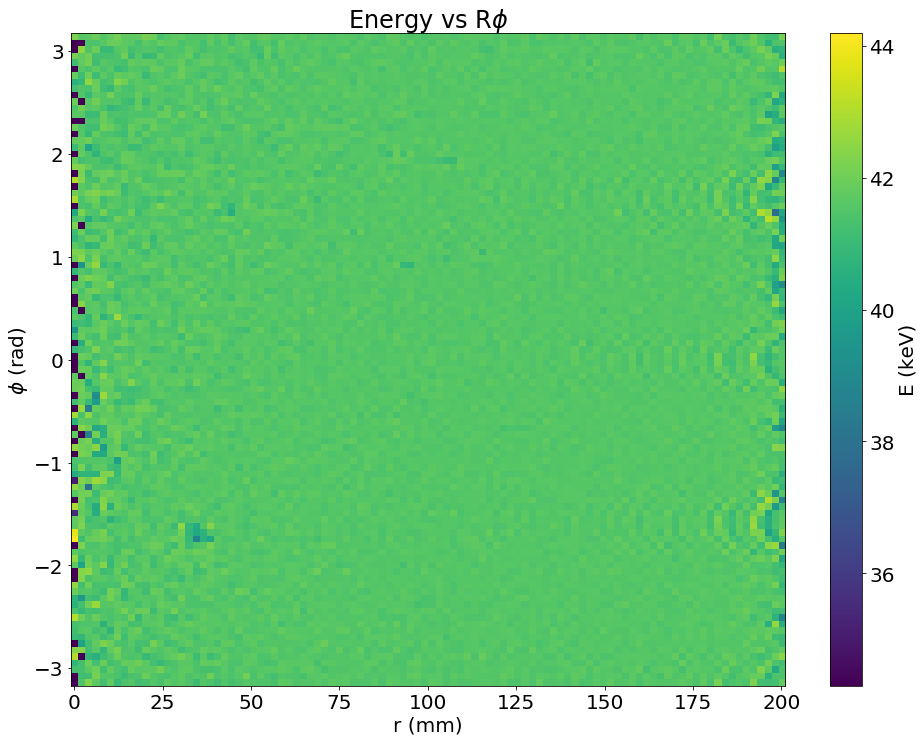

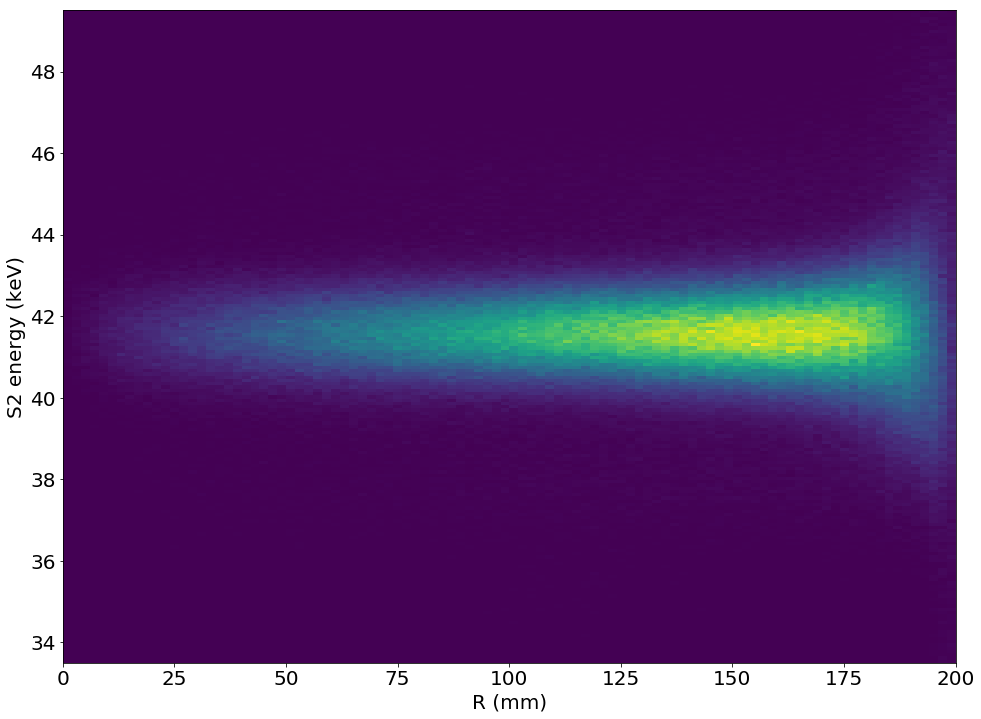

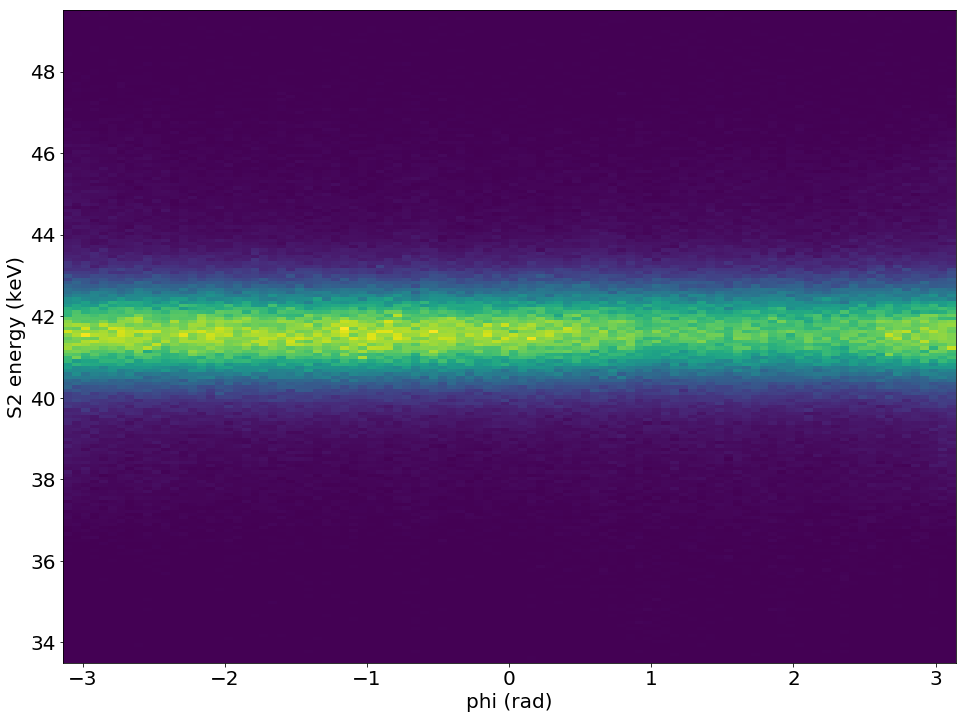

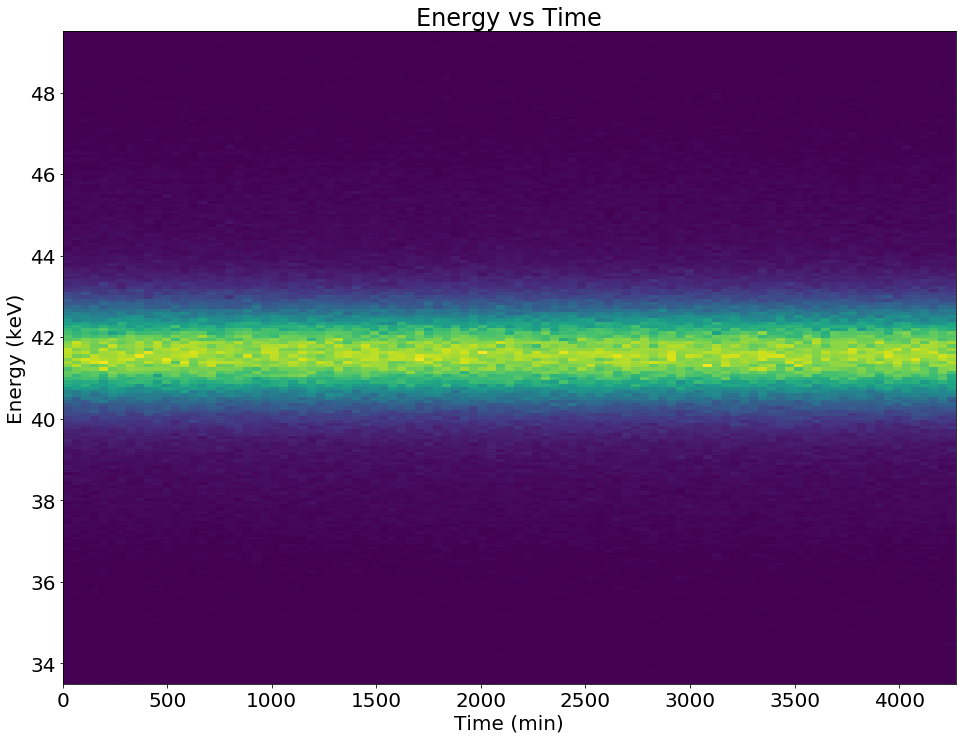

In [30]:
x, y, e, eu = \
fitf.profileXY(X, Y, E, XYnbins, XYnbins, XYrange, XYrange)
_, cb = display_matrix(x, y, e, vmin=np.min(e[e > 0]))
cb.set_label("E (keV)")
labels("x (mm)", "y (mm)", "Energy vs XY")
save("EnergyXY")

r, phi, e, eu = \
fitf.profileXY(R, Phi, E, Rnbins, Phinbins, Rrange, Phirange)
_, cb = display_matrix(r, phi, e, vmin=np.min(e[e > 0]))
cb.set_label("E (keV)")
labels("r (mm)", "$\phi$ (rad)", "Energy vs R$\phi$")
save("EnergyRPhi")

hist2d(R, E, (Rbins, Ebins))
labels("R (mm)", "S2 energy (keV)")
save("EnergyR")

hist2d(Phi, E, (Phibins, Ebins))
labels("phi (rad)", "S2 energy (keV)")
save("EnergyPhi")

hist2d(T, E, (np.linspace(0, T.max(), 100), Ebins))
labels("Time (min)", "Energy (keV)", "Energy vs Time")
save("EnergyTime")

##### Charge/Energy ratio

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


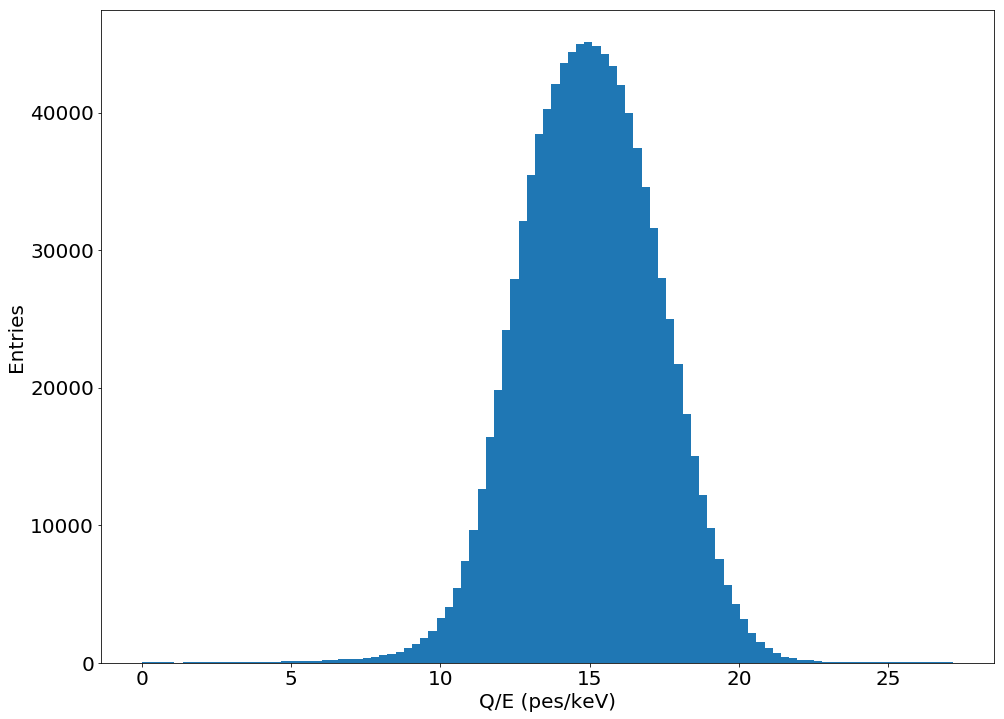

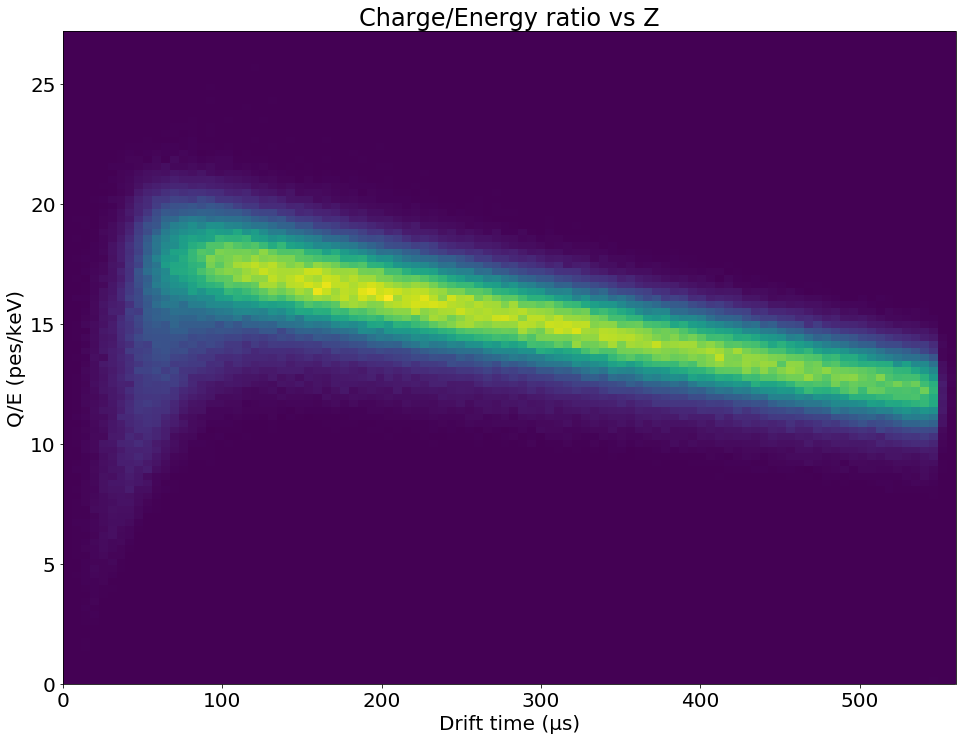

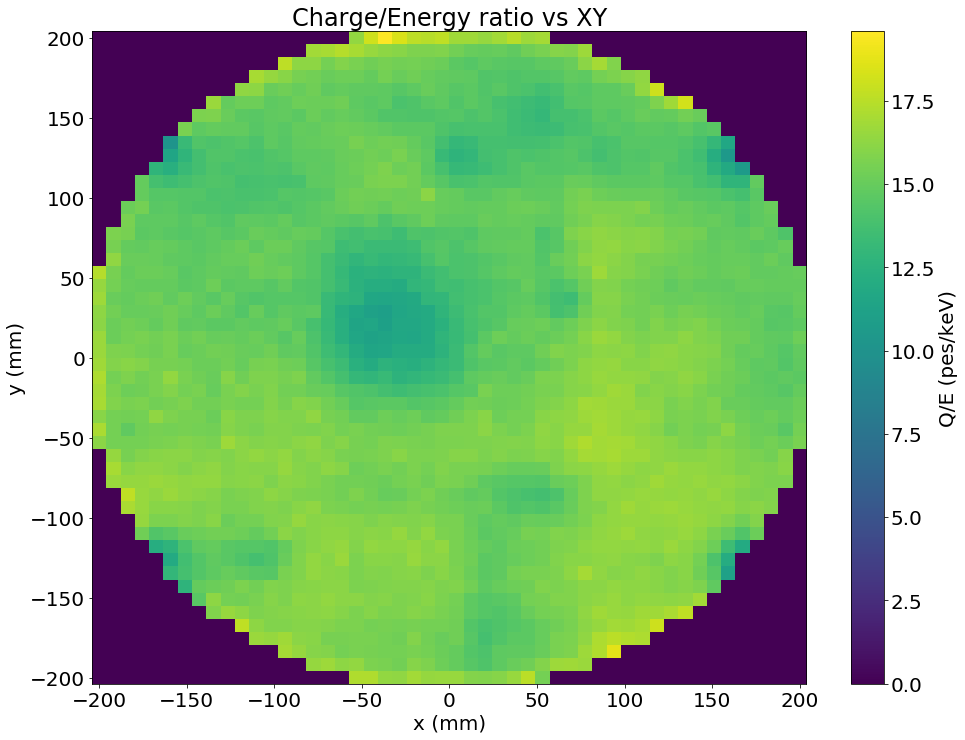

In [31]:
QEratio = S2q / E
QEratio = np.where(np.isfinite(QEratio), QEratio, 0)

QEbins = np.linspace(0, np.mean(QEratio) + 3 * np.std(QEratio), 100)
hist(QEratio, QEbins)
labels("Q/E (pes/keV)", "Entries")
save("QEratio")

hist2d(Z, QEratio, (Zbins, QEbins))
labels("Drift time (µs)", "Q/E (pes/keV)", "Charge/Energy ratio vs Z")
save("QEratioZ")

x, y, qe, qeu = \
fitf.profileXY(X, Y, QEratio, XYnbins, XYnbins, XYrange, XYrange)
_, cb = display_matrix(x, y, qe)
cb.set_label("Q/E (pes/keV)")
labels("x (mm)", "y (mm)", "Charge/Energy ratio vs XY")
save("QEratioXY")

##### Energy resolution

In [32]:
xy_data       = collections.namedtuple(      "xy_data", "x y xu yu"       )
reso_fit_data = collections.namedtuple("reso_fit_data", "xy residuals f R")

def measure_resolution(E):
    y, x  = np.histogram(E, Ebins)
    x     = shift_to_bin_centers(x)
    xu    = np.diff(x)[0] * 0.5
    yu    = poisson_sigma(y)

    fun   = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.polynom(x, *args[3:])
    Npeak = np.size(E) * np.diff(Ebins)[0]
    Epeak = np.average( x            , weights=y)
    Speak = np.average((x - Epeak)**2, weights=y)**0.5
    seed  = Npeak, Epeak, Speak, 1, 1, 1,

    fit_range = (Epeak - 3 * Speak,
                 Epeak + 3 * Speak)
    f    = fitf.fit(fun, x, y, seed,
                    fit_range = fit_range,
                    sigma     = yu)

    assert not np.any(np.isclose(f.values, seed)), f.values

    R   = resolution(f.values, f.errors, 41.5)
    sel = coref.in_range(x, *fit_range)
    ry  = (f.fn(x) - y) / yu
    return reso_fit_data(xy_data(x, y, xu, yu),
                         xy_data(x[sel], ry[sel], xu, yu[sel]),
                         f, R)

Resolution at 41.5 keV: 4.6125 +- 0.0071
Resolution at 2458 keV: 0.59933 +- 0.00092
Chi2                  : 5.44456340332


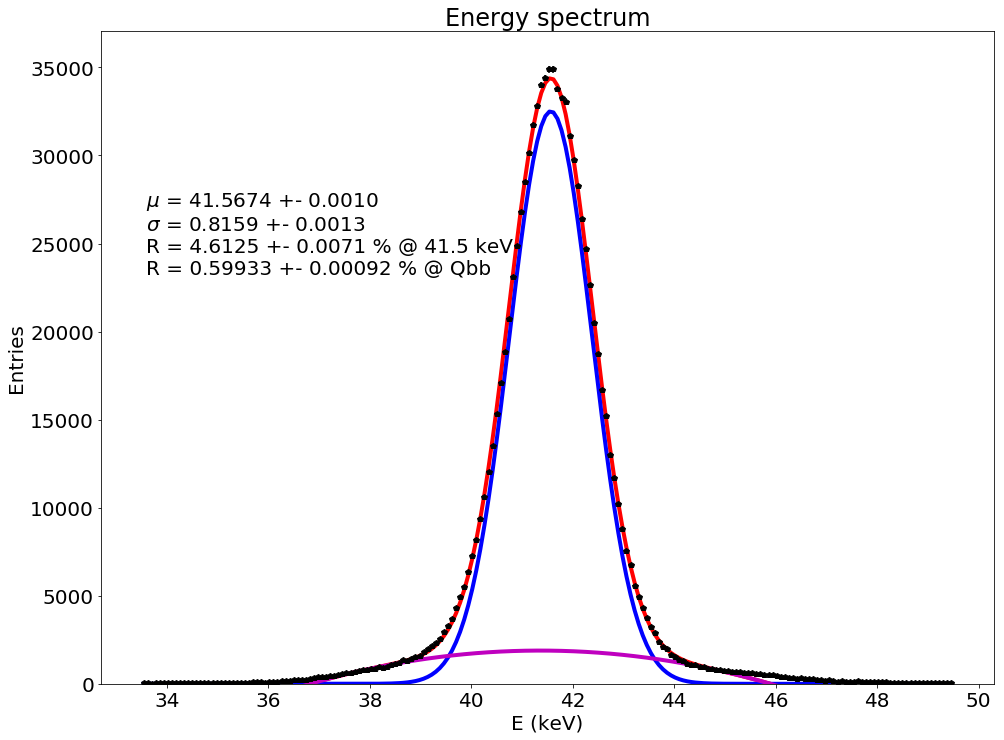

In [33]:
data = measure_resolution(E)

print("Resolution at 41.5 keV:", measurement_string(*data.R[0]))
print("Resolution at 2458 keV:", measurement_string(*data.R[1]))
print("Chi2                  :", data.f.chi2)

x = data.xy.x
plt.errorbar(x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
plt.plot    (x, data.f.fn   (x)                     , lw=global_linewidth, c=global_linecolor   )
plt.plot    (x, fitf.gauss  (x, *data.f.values[ :3]), lw=subfit_linewidth, c=subfit_linecolor[0])
plt.plot    (x, fitf.polynom(x, *data.f.values[3: ]), lw=subfit_linewidth, c=subfit_linecolor[1])
plt.text(plt.xlim()[0] + np.diff(plt.xlim()) * 0.05,
         max(data.xy.y) / 1.5,
         gausstext(data.f.values, data.f.errors, 41.5))


plt.ylim(0)
labels("E (keV)", "Entries", "Energy spectrum")
save("EnergySpectrum")

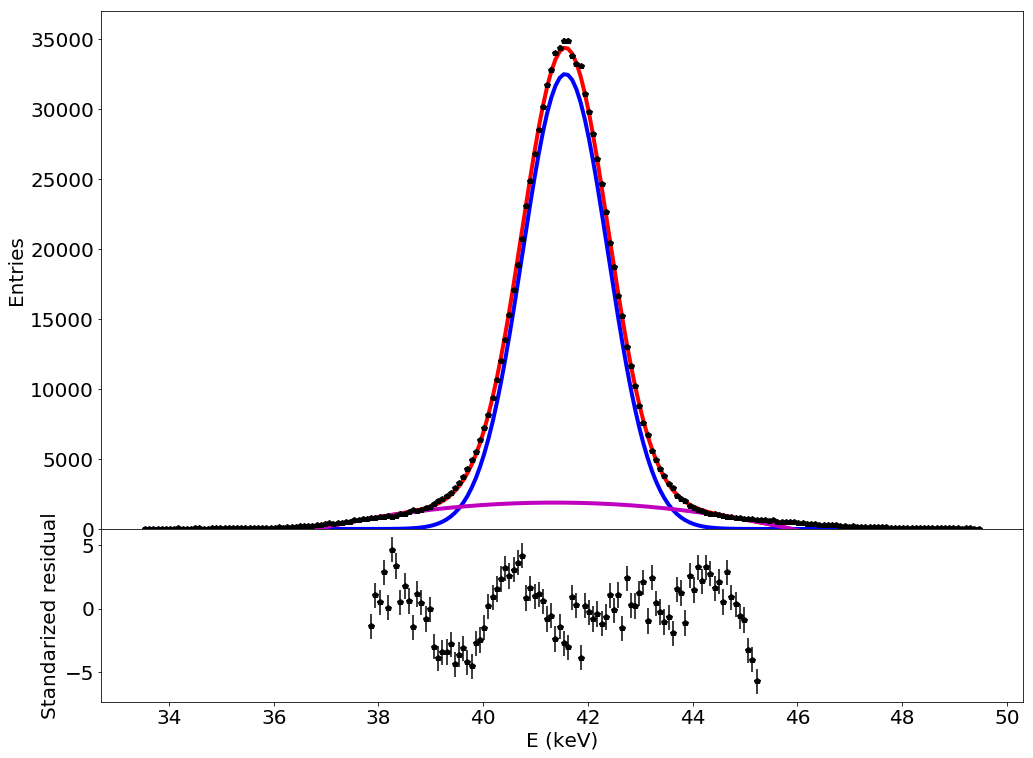

In [34]:
frame_data = plt.gcf().add_axes((.1, .3,
                                 .8, .6))
plt.errorbar(x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
plt.plot    (x, data.f.fn   (x)                     , lw=global_linewidth, c=global_linecolor   )
plt.plot    (x, fitf.gauss  (x, *data.f.values[ :3]), lw=subfit_linewidth, c=subfit_linecolor[0])
plt.plot    (x, fitf.polynom(x, *data.f.values[3: ]), lw=subfit_linewidth, c=subfit_linecolor[1])
frame_data.set_xticklabels([])
plt.ylabel("Entries")
plt.ylim(0)
lims = plt.xlim()

frame_res = plt.gcf().add_axes((.1, .1,
                                .8, .2))
plt.errorbar(data.residuals.x, data.residuals.y, 1, data.residuals.xu, fmt="p", c="k")
plt.xlim(*lims)
labels("E (keV)", "Standarized residual")
save("EnergySpectrumCool")

##### Energy resolution best case

Resolution at 41.5 keV: 4.267 +- 0.016
Resolution at 2458 keV: 0.5545 +- 0.0021
Chi2                  : 1.42746110488


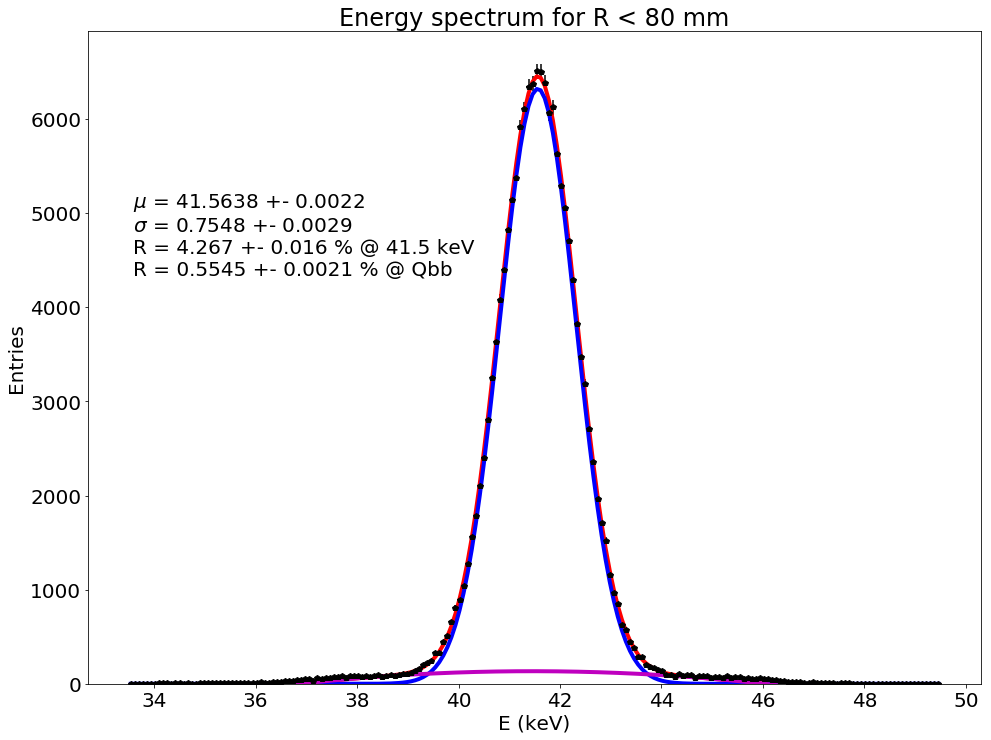

In [35]:
sel_r = coref.in_range(R, 0, R_fiducial)
data  = measure_resolution(E[sel_r])

print("Resolution at 41.5 keV:", measurement_string(*data.R[0]))
print("Resolution at 2458 keV:", measurement_string(*data.R[1]))
print("Chi2                  :", data.f.chi2)

x = data.xy.x
plt.errorbar(x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
plt.plot    (x, data.f.fn   (x)                     , lw=global_linewidth, c=global_linecolor)
plt.plot    (x, fitf.gauss  (x, *data.f.values[ :3]), lw=subfit_linewidth, c=subfit_linecolor[0])
plt.plot    (x, fitf.polynom(x, *data.f.values[3: ]), lw=subfit_linewidth, c=subfit_linecolor[1])
plt.text(plt.xlim()[0] + np.diff(plt.xlim()) * 0.05,
         max(data.xy.y) / 1.5,
         gausstext(data.f.values, data.f.errors, 41.5))


plt.ylim(0)
labels("E (keV)", "Entries", f"Energy spectrum for R < {R_fiducial:.0f} mm")
save("EnergySpectrumFiducialR")

Resolution at 41.5 keV: 4.163 +- 0.018
Resolution at 2458 keV: 0.5409 +- 0.0023
Chi2                  : 1.52966840356


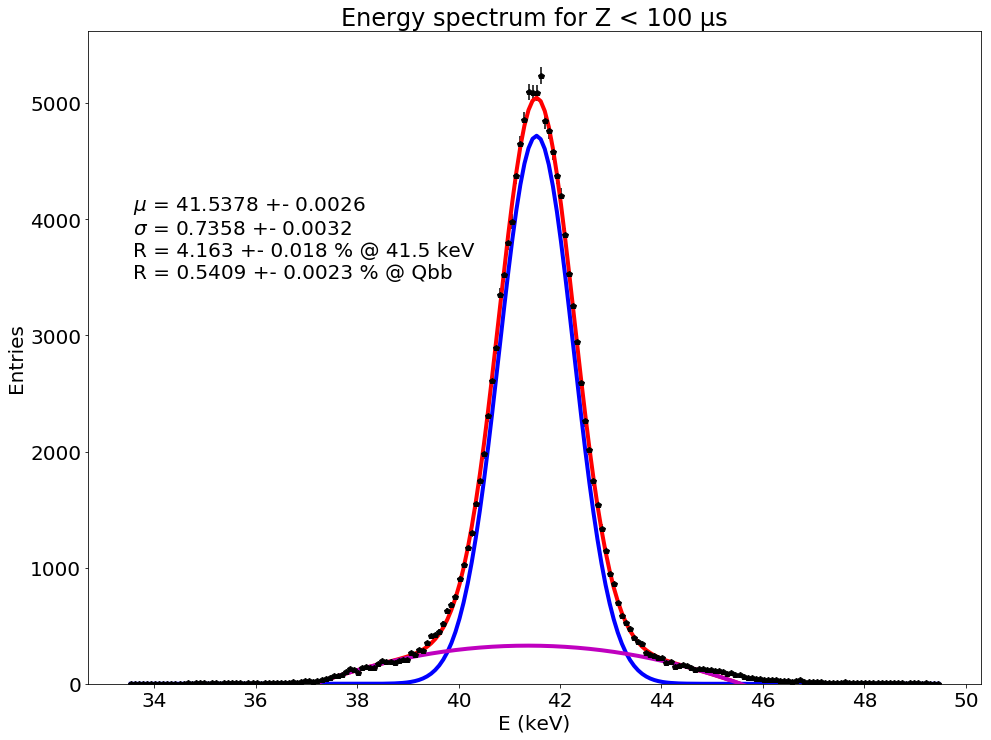

In [36]:
sel_z = coref.in_range(Z, 0, Z_fiducial)
data  = measure_resolution(E[sel_z])

print("Resolution at 41.5 keV:", measurement_string(*data.R[0]))
print("Resolution at 2458 keV:", measurement_string(*data.R[1]))
print("Chi2                  :", data.f.chi2)

x = data.xy.x
plt.errorbar(x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
plt.plot    (x, data.f.fn   (x)                     , lw=global_linewidth, c=global_linecolor)
plt.plot    (x, fitf.gauss  (x, *data.f.values[ :3]), lw=subfit_linewidth, c=subfit_linecolor[0])
plt.plot    (x, fitf.polynom(x, *data.f.values[3: ]), lw=subfit_linewidth, c=subfit_linecolor[1])
plt.text(plt.xlim()[0] + np.diff(plt.xlim()) * 0.05,
         max(data.xy.y) / 1.5,
         gausstext(data.f.values, data.f.errors, 41.5))


plt.ylim(0)
labels("E (keV)", "Entries", f"Energy spectrum for Z < {Z_fiducial:.0f} µs")
save("EnergySpectrumFiducialZ")

Resolution at 41.5 keV: 3.760 +- 0.042
Resolution at 2458 keV: 0.4885 +- 0.0055
Chi2                  : 0.86309169167


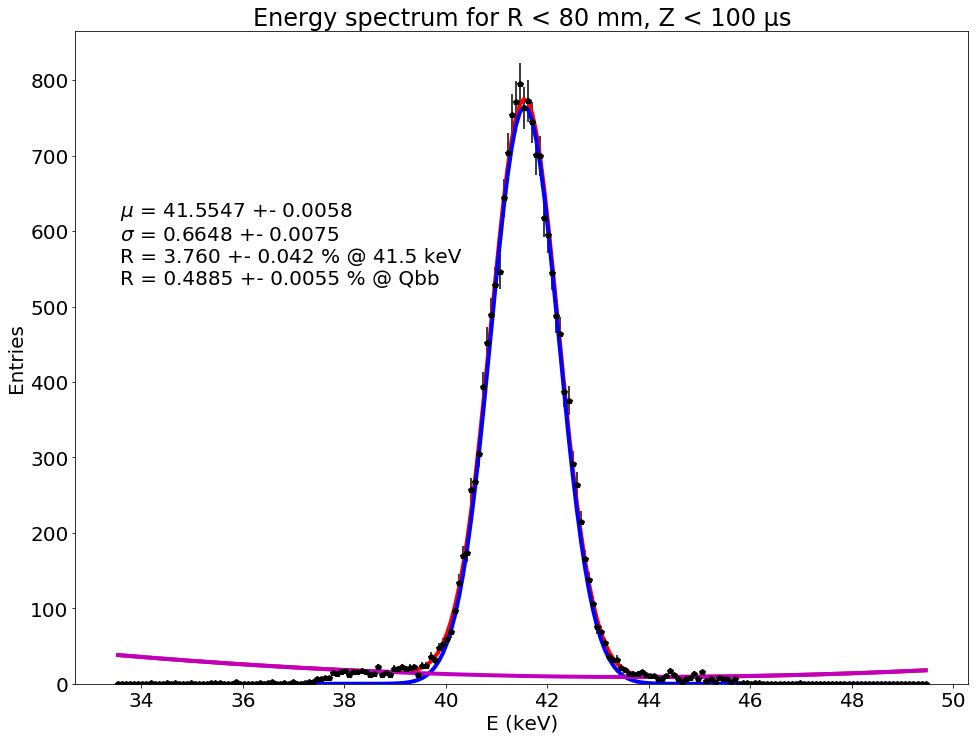

In [37]:
sel_r = coref.in_range(R, 0, R_fiducial)
sel_z = coref.in_range(Z, 0, Z_fiducial)
data  = measure_resolution(E[sel_r & sel_z])

print("Resolution at 41.5 keV:", measurement_string(*data.R[0]))
print("Resolution at 2458 keV:", measurement_string(*data.R[1]))
print("Chi2                  :", data.f.chi2)

x = data.xy.x
plt.errorbar(x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
plt.plot    (x, data.f.fn   (x)                     , lw=global_linewidth, c=global_linecolor)
plt.plot    (x, fitf.gauss  (x, *data.f.values[ :3]), lw=subfit_linewidth, c=subfit_linecolor[0])
plt.plot    (x, fitf.polynom(x, *data.f.values[3: ]), lw=subfit_linewidth, c=subfit_linecolor[1])
plt.text(plt.xlim()[0] + np.diff(plt.xlim()) * 0.05,
         max(data.xy.y) / 1.5,
         gausstext(data.f.values, data.f.errors, 41.5))


plt.ylim(0)
labels("E (keV)", "Entries", f"Energy spectrum for R < {R_fiducial:.0f} mm, Z < {Z_fiducial:.0f} µs")
save("EnergySpectrumFiducialRZ")

##### Energy resolution dependence

R in [0.0, 12.5) mm
| Resolution at 2458 keV: 0.474 +- 0.050
| Chi2                  : 0.826660445213
R in [12.5, 25.0) mm
| Resolution at 2458 keV: 0.481 +- 0.021
| Chi2                  : 0.740675686899
R in [25.0, 37.5) mm
| Resolution at 2458 keV: 0.469 +- 0.014
| Chi2                  : 0.882657226078
R in [37.5, 50.0) mm
| Resolution at 2458 keV: 0.476 +- 0.012
| Chi2                  : 0.635283117307
R in [50.0, 62.5) mm
| Resolution at 2458 keV: 0.524 +- 0.014
| Chi2                  : 0.917068142642
R in [62.5, 75.0) mm
| Resolution at 2458 keV: 0.482 +- 0.010
| Chi2                  : 0.733435859465
R in [75.0, 87.5) mm
| Resolution at 2458 keV: 0.4793 +- 0.0096
| Chi2                  : 1.03126008124
R in [87.5, 100.0) mm
| Resolution at 2458 keV: 0.4699 +- 0.0081
| Chi2                  : 0.927582967724
R in [100.0, 112.5) mm
| Resolution at 2458 keV: 0.4791 +- 0.0079
| Chi2                  : 0.805292924266
R in [112.5, 125.0) mm
| Resolution at 2458 keV: 0.4900 +- 0.0074


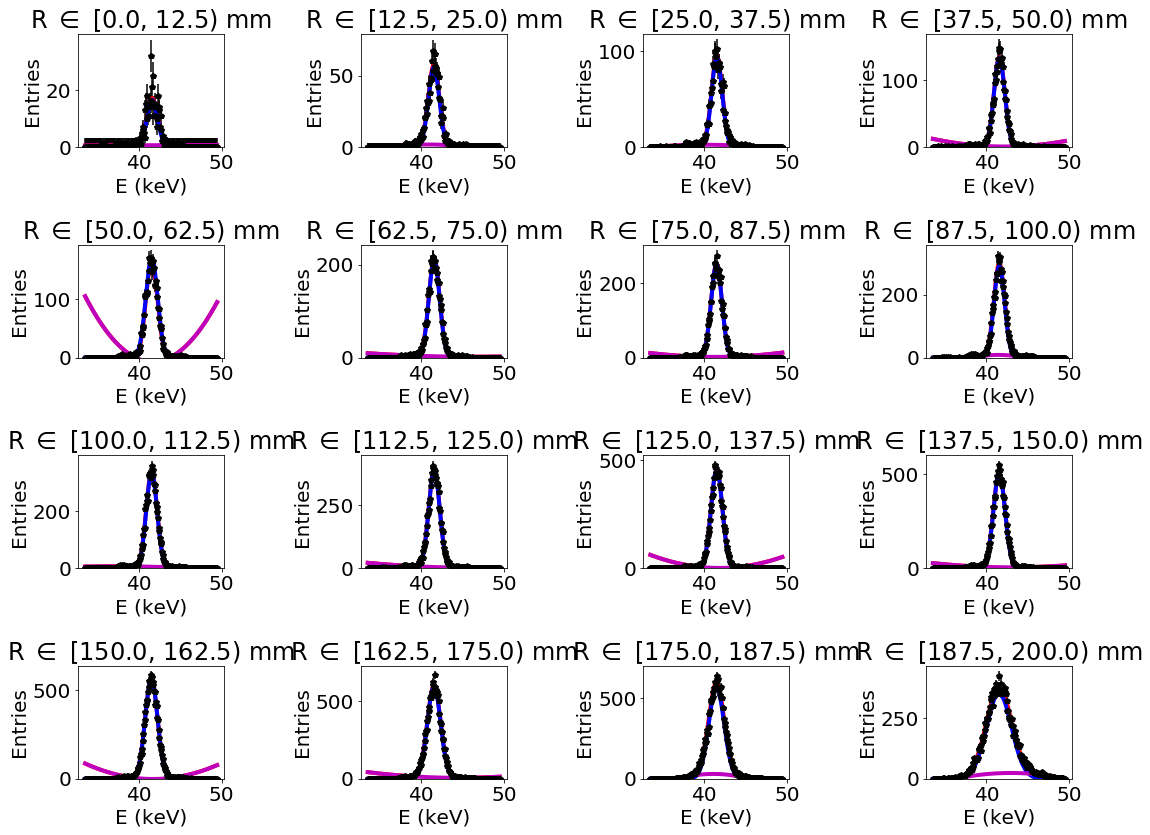

In [38]:
rbins = np.linspace(*Rrange, 17)
nbins = len(rbins) - 1
r     = shift_to_bin_centers(rbins)
dr    = 0.5 * np.diff       (rbins)

valid         = np.zeros(nbins, dtype=bool     )
Chi2          = np.zeros(nbins, dtype=np.double)
Resolution    = np.zeros(nbins, dtype=np.double)
Resolutionu   = np.zeros(nbins, dtype=np.double)
ResolutionBB  = np.zeros(nbins, dtype=np.double)
ResolutionBBu = np.zeros(nbins, dtype=np.double)

sel_z = coref.in_range(Z, 0, Z_fiducial)
for i in range(nbins):
    plt.subplot(4, 4, i+1)
    try:
        rmin, rmax = rbins[i:i+2]
        sel_r = coref.in_range(R, rmin, rmax)
        data  = measure_resolution(E[sel_r & sel_z])

        print(f"R in [{rmin:.1f}, {rmax:.1f}) mm")
        print( "| Resolution at 2458 keV:", measurement_string(*data.R[1]))
        print( "| Chi2                  :", data.f.chi2)

        x = data.xy.x
        plt.errorbar(x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
        plt.plot    (x, data.f.fn   (x)                     , lw=global_linewidth, c=global_linecolor)
        plt.plot    (x, fitf.gauss  (x, *data.f.values[ :3]), lw=subfit_linewidth, c=subfit_linecolor[0])
        plt.plot    (x, fitf.polynom(x, *data.f.values[3: ]), lw=subfit_linewidth, c=subfit_linecolor[1])

        plt.ylim(0)
        labels("E (keV)", "Entries", f"R $\in$ [{rmin:.1f}, {rmax:.1f}) mm")

        Resolution  [i], Resolutionu  [i] = data.R[0]
        ResolutionBB[i], ResolutionBBu[i] = data.R[1]
        Chi2        [i]                   = data.f.chi2
        valid       [i]                   = True
    except:
        pass

plt.tight_layout()
save("ResolutionRslices")

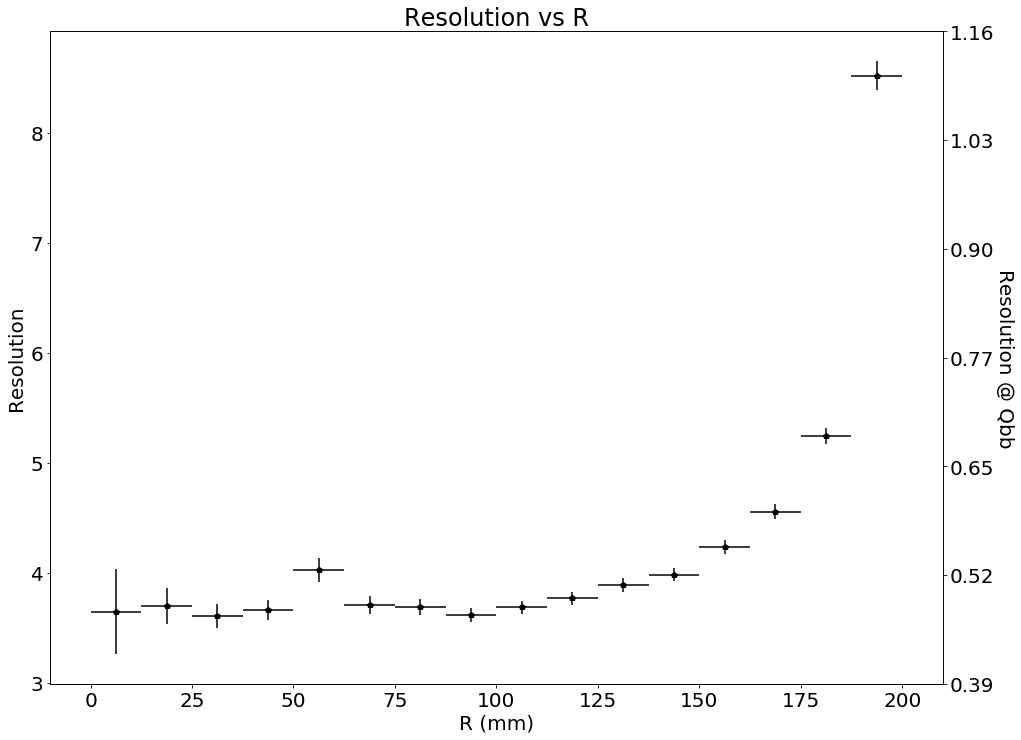

In [39]:
plt.errorbar(r[valid], Resolution[valid], Resolutionu[valid], dr[valid], "kp")
labels("R (mm)", "Resolution", "Resolution vs R")

new_lims  = [lim * (41.5 / 2458)**0.5 for lim in plt.ylim()]
new_ticks = np.linspace(*new_lims, 7)
str_ticks = ["{:.2f}".format(i) for i in new_ticks]
ax2       = plt.gca().twinx()

ax2.set_ylim       (*new_lims )
ax2.set_yticks     ( new_ticks)
ax2.set_yticklabels( str_ticks)
ax2.set_ylabel("Resolution @ Qbb", rotation=-90, labelpad=20);
save("ResolutionR")

Z in [0.0, 46.7) mm
| Resolution at 2458 keV: 0.486 +- 0.021
| Chi2                  : 0.700102869214
Z in [46.7, 93.3) mm
| Resolution at 2458 keV: 0.4874 +- 0.0065
| Chi2                  : 0.897308449475
Z in [93.3, 140.0) mm
| Resolution at 2458 keV: 0.5032 +- 0.0058
| Chi2                  : 1.03839993447
Z in [140.0, 186.7) mm
| Resolution at 2458 keV: 0.5205 +- 0.0058
| Chi2                  : 1.08327034046
Z in [186.7, 233.3) mm
| Resolution at 2458 keV: 0.5347 +- 0.0060
| Chi2                  : 1.03418774458
Z in [233.3, 280.0) mm
| Resolution at 2458 keV: 0.5531 +- 0.0062
| Chi2                  : 1.06465008281
Z in [280.0, 326.7) mm
| Resolution at 2458 keV: 0.5604 +- 0.0066
| Chi2                  : 0.942793709737
Z in [326.7, 373.3) mm
| Resolution at 2458 keV: 0.5873 +- 0.0075
| Chi2                  : 0.952310254796
Z in [373.3, 420.0) mm
| Resolution at 2458 keV: 0.6038 +- 0.0082
| Chi2                  : 1.13445209576
Z in [420.0, 466.7) mm
| Resolution at 2458 keV: 0

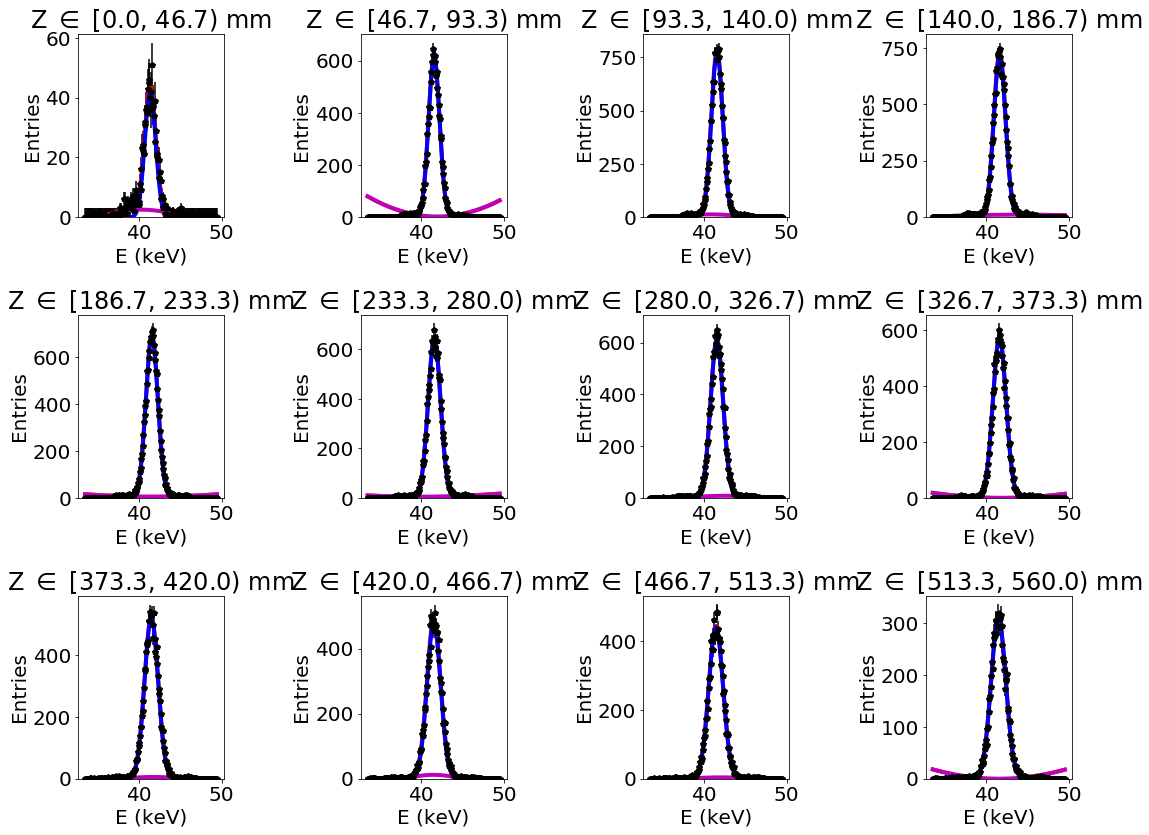

In [40]:
zbins = np.linspace(*Zrange, 13)
nbins = len(zbins) - 1
z     = shift_to_bin_centers(zbins)
dz    = 0.5 * np.diff       (zbins)

valid         = np.zeros(nbins, dtype=bool     )
Chi2          = np.zeros(nbins, dtype=np.double)
Resolution    = np.zeros(nbins, dtype=np.double)
Resolutionu   = np.zeros(nbins, dtype=np.double)
ResolutionBB  = np.zeros(nbins, dtype=np.double)
ResolutionBBu = np.zeros(nbins, dtype=np.double)

sel_r = coref.in_range(R, 0, R_fiducial)
for i in range(nbins):
    plt.subplot(3, 4, i+1)
    try:
        zmin, zmax = zbins[i:i+2]
        sel_z = coref.in_range(Z, zmin, zmax)
        data  = measure_resolution(E[sel_r & sel_z])

        print(f"Z in [{zmin:.1f}, {zmax:.1f}) mm")
        print( "| Resolution at 2458 keV:", measurement_string(*data.R[1]))
        print( "| Chi2                  :", data.f.chi2)

        x = data.xy.x
        plt.errorbar(x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
        plt.plot    (x, data.f.fn   (x)                     , lw=global_linewidth, c=global_linecolor)
        plt.plot    (x, fitf.gauss  (x, *data.f.values[ :3]), lw=subfit_linewidth, c=subfit_linecolor[0])
        plt.plot    (x, fitf.polynom(x, *data.f.values[3: ]), lw=subfit_linewidth, c=subfit_linecolor[1])

        plt.ylim(0)
        labels("E (keV)", "Entries", f"Z $\in$ [{zmin:.1f}, {zmax:.1f}) mm")

        Resolution  [i], Resolutionu  [i] = data.R[0]
        ResolutionBB[i], ResolutionBBu[i] = data.R[1]
        Chi2        [i]                   = data.f.chi2
        valid       [i]                   = True
    except:
        pass

plt.tight_layout()
save("ResolutionZslices")

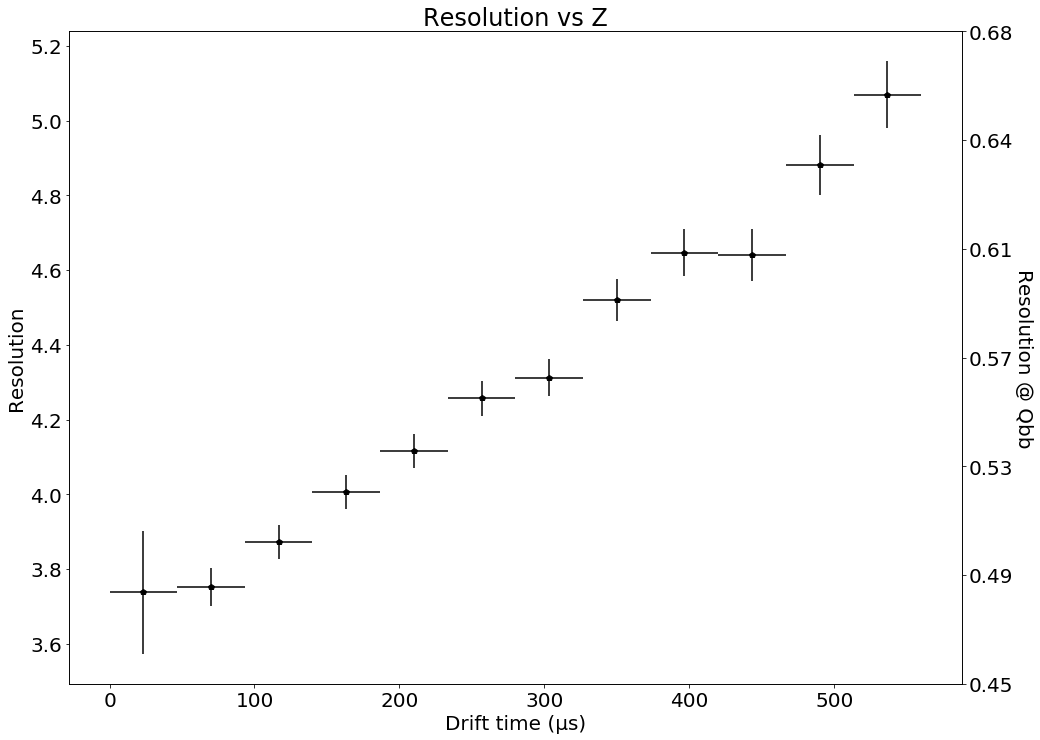

In [41]:
plt.errorbar(z[valid], Resolution[valid], Resolutionu[valid], dz[valid], "kp")
labels("Drift time (µs)", "Resolution", "Resolution vs Z")

new_lims  = [lim * (41.5 / 2458)**0.5 for lim in plt.ylim()]
new_ticks = np.linspace(*new_lims, 7)
str_ticks = ["{:.2f}".format(i) for i in new_ticks]
ax2       = plt.gca().twinx()

ax2.set_ylim       (*new_lims )
ax2.set_yticks     ( new_ticks)
ax2.set_yticklabels( str_ticks)
ax2.set_ylabel("Resolution @ Qbb", rotation=-90, labelpad=20);
save("ResolutionZ")

/Users/Gonzalo/github/IC/invisible_cities/core/fit_functions.py:28: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(cov))
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


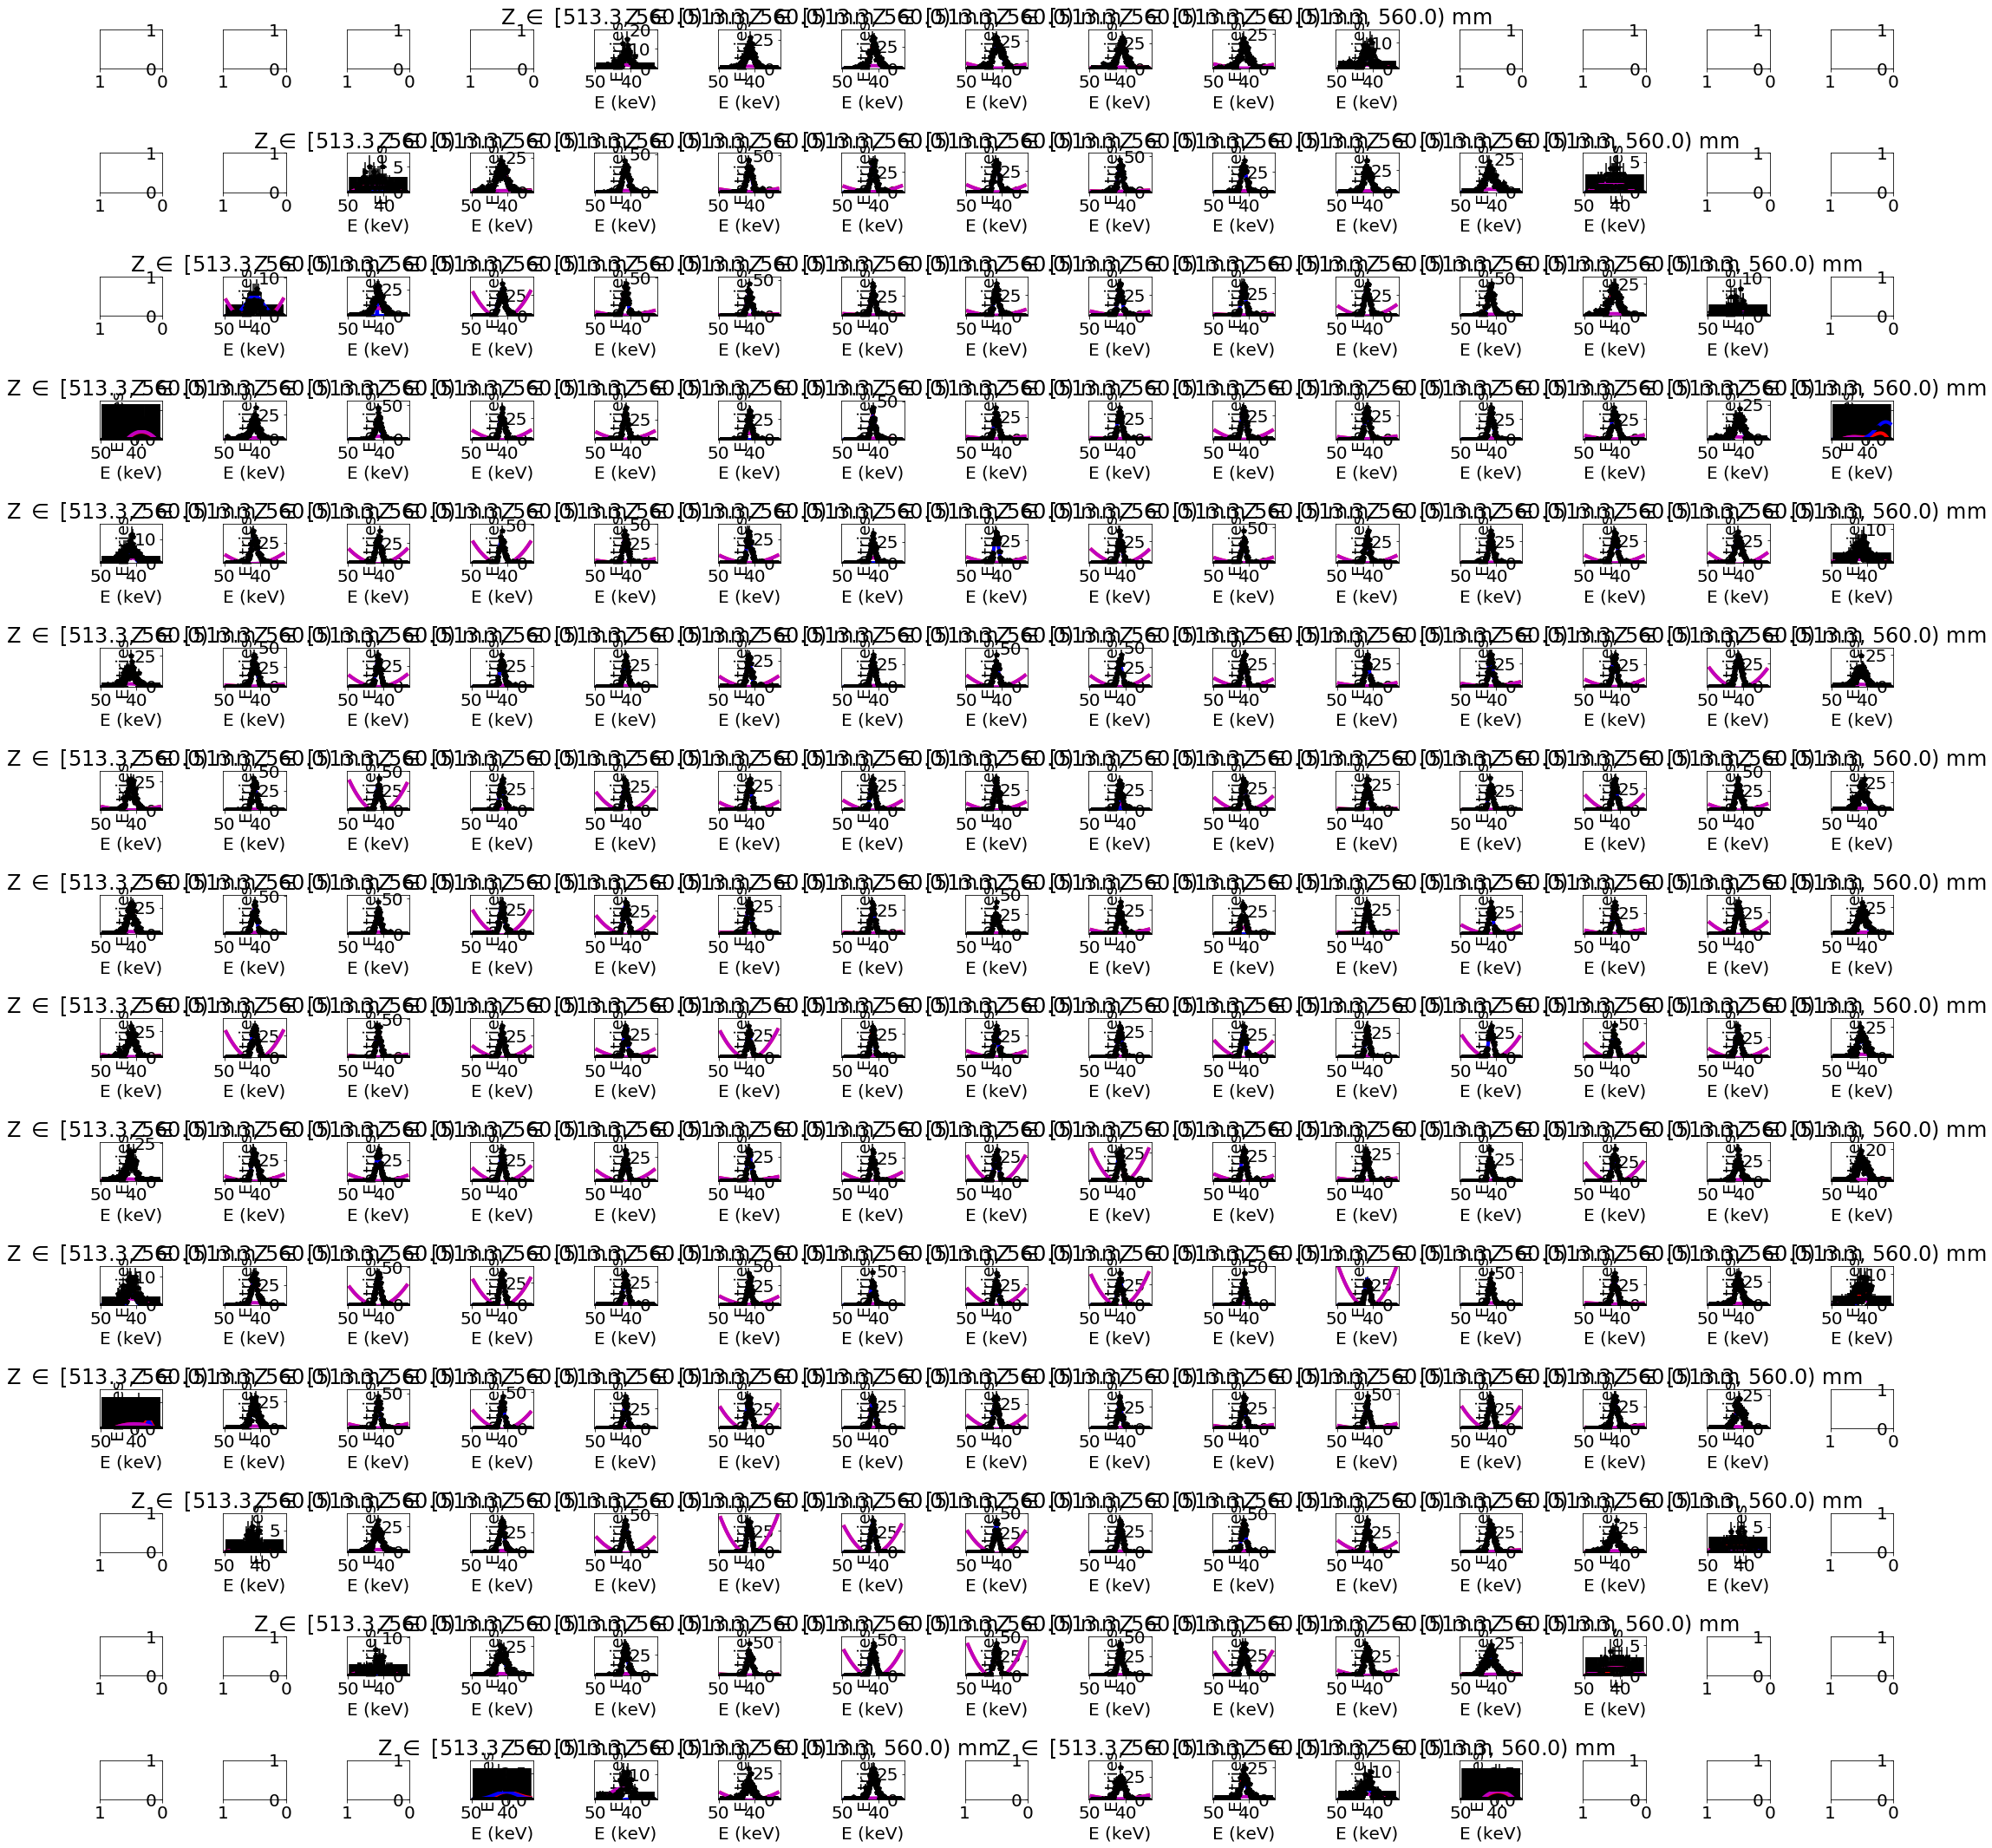

In [42]:
xybins = np.linspace(*XYrange, 16)
nbins  = len(xybins) - 1
xy     = shift_to_bin_centers(xybins)
dxy    = 0.5 * np.diff       (xybins)

valid         = np.zeros((nbins, nbins), dtype=bool     )
Chi2          = np.zeros((nbins, nbins), dtype=np.double)
Resolution    = np.zeros((nbins, nbins), dtype=np.double)
Resolutionu   = np.zeros((nbins, nbins), dtype=np.double)
ResolutionBB  = np.zeros((nbins, nbins), dtype=np.double)
ResolutionBBu = np.zeros((nbins, nbins), dtype=np.double)

plt.figure(figsize=(30, 30))

sel_z = coref.in_range(Z, 0, Z_fiducial)
for i in range(nbins):
    for j in range(nbins):
        plt.subplot(nbins, nbins, i * nbins + j + 1)

        xmin, xmax = xybins[i : i + 2]
        ymin, ymax = xybins[j : j + 2]
        sel_x = coref.in_range(X, xmin, xmax)
        sel_y = coref.in_range(Y, ymin, ymax)

        try:
            data  = measure_resolution(E[sel_x & sel_y & sel_z])

            x = data.xy.x
            plt.errorbar(x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
            plt.plot    (x, data.f.fn   (x)                     , lw=global_linewidth, c=global_linecolor)
            plt.plot    (x, fitf.gauss  (x, *data.f.values[ :3]), lw=subfit_linewidth, c=subfit_linecolor[0])
            plt.plot    (x, fitf.polynom(x, *data.f.values[3: ]), lw=subfit_linewidth, c=subfit_linecolor[1])

            plt.ylim(0)
            labels("E (keV)", "Entries", f"Z $\in$ [{zmin:.1f}, {zmax:.1f}) mm")

            Resolution  [i, j], Resolutionu  [i, j] = data.R[0]
            ResolutionBB[i, j], ResolutionBBu[i, j] = data.R[1]
            Chi2        [i, j]                      = data.f.chi2
            valid       [i, j]                      = True
        except:
            pass

plt.tight_layout()
save("ResolutionXYbins")

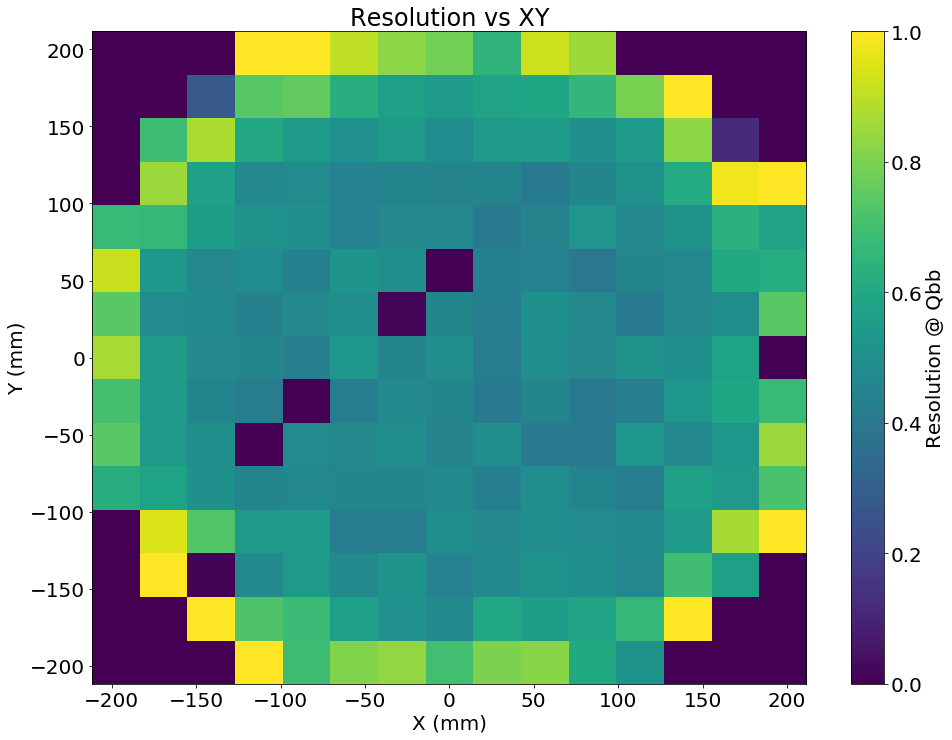

In [43]:
*_, cb = display_matrix(xy, xy, ResolutionBB, vmin = 0, vmax = 1)
cb.set_label("Resolution @ Qbb")
labels("X (mm)", "Y (mm)", "Resolution vs XY")
save("ResolutionXY")